In [1]:
from Funcs.Utility import *

In [2]:
LABELS_PROC = pd.read_csv(os.path.join(PATH_INTERMEDIATE, 'labels_1h_esmsyn.csv'), index_col=['pcode','timestamp'],parse_dates=True)
PARTICIPANTS = pd.read_csv(os.path.join(PATH_INTERMEDIATE, 'UserInfo.csv'),index_col = 'pcode')

In [3]:
p = os.path.join(PATH_INTERMEDIATE, 'step_count_binary_personal-15min.pkl')
X, y, groups, t, datetimes = load(p)

In [4]:
X

,PIF#participationStartTimestamp,PIF#age,PIF#openness,PIF#conscientiousness,PIF#neuroticism,PIF#extraversion,PIF#agreeableness,PIF#GHQ12,PIF#PSS10,PIF#CESD-R,...,PWR#RLV_SUP_TodayAfternoon,PWR#ETP#_TodayLateAfternoon,PWR#ASC#_TodayLateAfternoon,PWR#RLV_SUP_TodayLateAfternoon,PWR#ETP#_TodayEvening,PWR#ASC#_TodayEvening,PWR#RLV_SUP_TodayEvening,PWR#ETP#_TodayNight,PWR#ASC#_TodayNight,PWR#RLV_SUP_TodayNight
0,1.637712e+12,23.0,11.0,12.0,3.0,10.0,9.0,9.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.637712e+12,23.0,11.0,12.0,3.0,10.0,9.0,9.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.637712e+12,23.0,11.0,12.0,3.0,10.0,9.0,9.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.637712e+12,23.0,11.0,12.0,3.0,10.0,9.0,9.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.637712e+12,23.0,11.0,12.0,3.0,10.0,9.0,9.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21614,1.638922e+12,20.0,10.0,8.0,4.0,7.0,14.0,7.0,12.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21615,1.638922e+12,20.0,10.0,8.0,4.0,7.0,14.0,7.0,12.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21616,1.638922e+12,20.0,10.0,8.0,4.0,7.0,14.0,7.0,12.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21617,1.638922e+12,20.0,10.0,8.0,4.0,7.0,14.0,7.0,12.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
#Divide the features into different categories
feat_current = X.loc[:,[('#VAL' in str(x)) or ('ESM#LastLabel' in str(x)) for x in X.keys()]]  
feat_dsc = X.loc[:,[('#DSC' in str(x))  for x in X.keys()]]  
feat_yesterday = X.loc[:,[('Yesterday' in str(x))  for x in X.keys()]]  
feat_today = X.loc[:,[('Today' in str(x))  for x in X.keys()]]  
feat_sleep = X.loc[:,[('Sleep' in str(x))  for x in X.keys()]]  
feat_time = X.loc[:,[('Time' in str(x))  for x in X.keys()]]  
feat_pif = X.loc[:,[('PIF' in str(x))  for x in X.keys()]]  
feat_ImmediatePast = X.loc[:,[('ImmediatePast_15' in str(x))  for x in X.keys()]]
#Divide the time window features into sensor/past stress label
feat_current_sensor = X.loc[:,[('#VAL' in str(x))  for x in X.keys()]]  
feat_current_ESM = X.loc[:,[('ESM#LastLabel' in str(x)) for x in X.keys()]]  
feat_ImmediatePast_sensor = feat_ImmediatePast.loc[:,[('ESM' not in str(x)) for x in feat_ImmediatePast.keys()]]  
feat_ImmediatePast_ESM = feat_ImmediatePast.loc[:,[('ESM'  in str(x)) for x in feat_ImmediatePast.keys()]]  
feat_today_sensor = feat_today.loc[:,[('ESM' not in str(x))  for x in feat_today.keys()]]  
feat_today_ESM = feat_today.loc[:,[('ESM'  in str(x)) for x in feat_today.keys()]]  
feat_yesterday_sensor = feat_yesterday.loc[:,[('ESM' not in str(x)) for x in feat_yesterday.keys()]]  
feat_yesterday_ESM = feat_yesterday.loc[:,[('ESM'  in str(x)) for x in feat_yesterday.keys()]]

In [6]:
feat_baseline = pd.concat([ feat_time,feat_dsc,feat_current_sensor, feat_ImmediatePast_sensor],axis=1)
feat_final = pd.concat([feat_baseline  ], axis=1)
# # Fill NaN values with zeros
feat_final = feat_final.fillna(0)
X = feat_final
cats = X.columns[X.dtypes == bool]

In [7]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone

normalize =True
# Feature selection method
selector = SelectFromModel(
        estimator=LogisticRegression(penalty='l1', solver='liblinear', C=1, random_state=seed, max_iter=4000),
        threshold=0.005
#         estimator=LinearSVC(
#         penalty='l1',
#         loss='squared_hinge',
#         dual=False,
#         tol=1e-3,
#         C=1e-2,
#         max_iter=5000,
#         random_state=RANDOM_STATE
#     )  
    )
select = [clone(selector)]
oversample = True

In [8]:
import os
import pandas as pd
import numpy as np
import ray
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from imblearn.over_sampling import SMOTENC, SMOTE
from tqdm import tqdm
from sklearn.model_selection import StratifiedGroupKFold, GroupKFold, KFold, TimeSeriesSplit, LeavePGroupsOut, train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder



def get_cv_splits(cv_strategy, data, labels, groups=None):
    """
    Returns the train-test splits based on the chosen cross-validation strategy.
    """
    if cv_strategy == 'loso':
        cv = LeaveOneGroupOut()
        return cv.split(data, labels, groups)
    elif cv_strategy == 'group_k_fold':
        cv = GroupKFold(n_splits=5)  # You can adjust the number of splits
        return cv.split(data, labels, groups)
    elif cv_strategy == 'k_fold':
        cv = KFold(n_splits=5)  # You can adjust the number of splits
        return cv.split(data)
    elif cv_strategy == 'time_series':
        cv = TimeSeriesSplit(n_splits=5)  # You can adjust the number of splits
        return cv.split(data)
    else:
        raise ValueError(f"Unknown CV strategy: {cv_strategy}")


def get_categorical_features_indices(df):
    return [i for i, col in enumerate(df.columns) if df[col].nunique() <= 10]

def exclude_low_variance(agg_feature, threshold=.0000001):
    agg_feature_non_zero_var = agg_feature.loc[:,agg_feature.var()>threshold]
    num_removed = agg_feature.shape[1]-agg_feature_non_zero_var.shape[1]
    print(f'{num_removed}/{agg_feature.shape[1]} features with variance < {threshold} removed')
    return agg_feature_non_zero_var

def remove_pairwise_corr(agg_feature_percent_missing, PAIRWISE_CORR_THRESHOLD=0.8, outcome_variable=None):
    if outcome_variable is not None:
        outcome_variable = pd.Series(outcome_variable, index=agg_feature_percent_missing.index, name="outcome")
        corr_with_outcome = pd.merge(outcome_variable, agg_feature_percent_missing, left_index=True, right_index=True).corr()[outcome_variable.name].abs().sort_values(ascending=False)
        importance_order = corr_with_outcome.index[1:].tolist()
        agg_feature_percent_missing = agg_feature_percent_missing[importance_order]

    Matrix = agg_feature_percent_missing.corr().abs()
    
    upper_triangle = Matrix.where(np.triu(np.ones(Matrix.shape), k=1).astype(bool))

    correlated_features = set()
    for feature in upper_triangle.columns:
        highly_correlated = upper_triangle[feature][upper_triangle[feature] > PAIRWISE_CORR_THRESHOLD].index
        correlated_features.update(highly_correlated)

    kept_features = list(set(agg_feature_percent_missing.columns) - correlated_features)
    print(f"Pairwise Corr: kept only {len(kept_features)}/{len(agg_feature_percent_missing.columns)} features")
    return agg_feature_percent_missing[kept_features]



# Feature selection method
def feature_selector(X_train, y_train):
    selector = SelectFromModel(
        estimator=LogisticRegression(penalty='l1', solver='liblinear', C=1, random_state=seed, max_iter=4000),
        threshold=0.005
#         estimator=LinearSVC(
#         penalty='l1',
#         loss='squared_hinge',
#         dual=False,
#         tol=1e-3,
#         C=1e-2,
#         max_iter=5000,
#         random_state=RANDOM_STATE
#     )
    
    )
    selector.fit(X_train, y_train)
    return selector

def split_train_test(df, labels, train_idx, test_idx):
    X_train = df.iloc[train_idx]
    y_train = labels[train_idx]
    X_test = df.iloc[test_idx]
    y_test = labels[test_idx]
    return X_train, y_train, X_test, y_test

def process_dataframe(X):
    """
    Process the input DataFrame 'X':
    1. Set column names as a range from 0 to the number of columns.
    2. Replace boolean values with 1 for True and 0 for False.

    Parameters:
        X (pandas.DataFrame): The input DataFrame.

    Returns:
        pandas.DataFrame: The processed DataFrame.
    """
    # Set column names as a range from 0 to the number of columns
    X.columns = range(X.shape[1])

    # Replace boolean values with 1 for True and 0 for False
#     X = X * 1

    return X

def save_data_to_data_file(X, y, filename):
    if not os.path.exists(PATH_SAVE_STEPS):
        os.makedirs(PATH_SAVE_STEPS)

    file_path = os.path.join(PATH_SAVE_STEPS, filename)

    with open(file_path, 'w') as f:
        for i in range(len(X)):
            # Check if y is a numpy array or dataframe
            label = y[i] if isinstance(y, np.ndarray) else y.iloc[i].values[0]
            
            # Start building the line with the label
            line = str(label)
            
            # Iterate through columns of X
            for col_idx, value in enumerate(X[i] if isinstance(X, np.ndarray) else X.iloc[i]):
                line += " {}:{}".format(col_idx, value)
            
            f.write(line + '\n')

In [9]:
import os
import pandas as pd
import numpy as np
import ray
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from imblearn.over_sampling import SMOTENC, SMOTE
from tqdm import tqdm
from sklearn.model_selection import StratifiedGroupKFold, GroupKFold, KFold, TimeSeriesSplit, LeavePGroupsOut, train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder



def get_cv_splits(cv_strategy, data, labels, groups=None):
    """
    Returns the train-test splits based on the chosen cross-validation strategy.
    """
    if cv_strategy == 'loso':
        cv = LeaveOneGroupOut()
        return cv.split(data, labels, groups)
    elif cv_strategy == 'group_k_fold':
        cv = GroupKFold(n_splits=5)  # You can adjust the number of splits
        return cv.split(data, labels, groups)
    elif cv_strategy == 'k_fold':
        cv = KFold(n_splits=5)  # You can adjust the number of splits
        return cv.split(data)
    elif cv_strategy == 'time_series':
        cv = TimeSeriesSplit(n_splits=5)  # You can adjust the number of splits
        return cv.split(data)
    else:
        raise ValueError(f"Unknown CV strategy: {cv_strategy}")


def get_categorical_features_indices(df):
    return [i for i, col in enumerate(df.columns) if df[col].nunique() <= 10]

def exclude_low_variance(agg_feature, threshold=.0000001):
    agg_feature_non_zero_var = agg_feature.loc[:,agg_feature.var()>threshold]
    num_removed = agg_feature.shape[1]-agg_feature_non_zero_var.shape[1]
    print(f'{num_removed}/{agg_feature.shape[1]} features with variance < {threshold} removed')
    return agg_feature_non_zero_var

def remove_pairwise_corr(agg_feature_percent_missing, PAIRWISE_CORR_THRESHOLD=0.8, outcome_variable=None):
    if outcome_variable is not None:
        outcome_variable = pd.Series(outcome_variable, index=agg_feature_percent_missing.index, name="outcome")
        corr_with_outcome = pd.merge(outcome_variable, agg_feature_percent_missing, left_index=True, right_index=True).corr()[outcome_variable.name].abs().sort_values(ascending=False)
        importance_order = corr_with_outcome.index[1:].tolist()
        agg_feature_percent_missing = agg_feature_percent_missing[importance_order]

    Matrix = agg_feature_percent_missing.corr().abs()
    
    upper_triangle = Matrix.where(np.triu(np.ones(Matrix.shape), k=1).astype(bool))

    correlated_features = set()
    for feature in upper_triangle.columns:
        highly_correlated = upper_triangle[feature][upper_triangle[feature] > PAIRWISE_CORR_THRESHOLD].index
        correlated_features.update(highly_correlated)

    kept_features = list(set(agg_feature_percent_missing.columns) - correlated_features)
    print(f"Pairwise Corr: kept only {len(kept_features)}/{len(agg_feature_percent_missing.columns)} features")
    return agg_feature_percent_missing[kept_features]



# Feature selection method
def feature_selector(X_train, y_train):
    selector = SelectFromModel(
        estimator=LogisticRegression(penalty='l1', solver='liblinear', C=1, random_state=seed, max_iter=4000),
        threshold=0.005
#         estimator=LinearSVC(
#         penalty='l1',
#         loss='squared_hinge',
#         dual=False,
#         tol=1e-3,
#         C=1e-2,
#         max_iter=5000,
#         random_state=RANDOM_STATE
#     )
    
    )
    selector.fit(X_train, y_train)
    return selector

def split_train_test(df, labels, train_idx, test_idx):
    X_train = df.iloc[train_idx]
    y_train = labels[train_idx]
    X_test = df.iloc[test_idx]
    y_test = labels[test_idx]
    return X_train, y_train, X_test, y_test



# @ray.remote
# # def process_and_save_split(train_idx, test_idx, all_data, all_labels, all_groups, process_dataframe, save_data_to_data_file, C_cat, C_num, select):
# def process_and_save_split(train_idx, test_idx, all_data, all_labels, all_groups, process_dataframe, save_data_to_data_file):
#     X_train, y_train, X_test, y_test = split_train_test(all_data, all_labels, train_idx, test_idx)
    
# #     # Use LOSO to split the training set further into training and evaluation sets
# #     loso = LeaveOneGroupOut()
# #     train_indices, eval_indices = next(loso.split(X_train, y_train, groups=all_groups[train_idx]))    
# #     X_eval, y_eval = X_train.iloc[eval_indices], y_train[eval_indices]
# #     X_train, y_train = X_train.iloc[train_indices], y_train[train_indices]
    
#     # Split 20% of training set as eval set
#     X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_STATE)

# #     # Split 20% of training set as eval set based on groups
# #     gss = GroupShuffleSplit(test_size=0.2, random_state=RANDOM_STATE)
# #     train_inds, eval_inds = next(gss.split(X_train, y_train, groups=all_groups[train_idx]))
# #     X_eval, y_eval = X_train.iloc[eval_inds], y_train[eval_inds]
# #     X_train, y_train = X_train.iloc[train_inds], y_train[train_inds]
    
#     # Apply SMOTENC
#     smote_nc = SMOTENC(categorical_features=get_categorical_features_indices(X_train), random_state=RANDOM_STATE)
#     X_train, y_train = smote_nc.fit_resample(X_train, y_train)
    
# #     #Removing low variance features
# #     X_train = exclude_low_variance(X_train)
# #     X_test = X_test[X_train.columns]  # Keep only the selected features in the test set

# #     #Removing highly correlated features
# #     X_train = remove_pairwise_corr(X_train, outcome_variable= y_train)
# #     X_test = X_test[X_train.columns]  # Keep only the selected features in the test set
    
#     # Capture indices 
#     train_indices = X_train.index
#     eval_indices = X_eval.index
#     test_indices = X_test.index
    
#     # Before feature selection, capture the columns
#     current_columns = X_train.columns
    
#     # Feature selection
#     selector = feature_selector(X_train, y_train)
#     X_train = selector.transform(X_train)
#     X_eval = selector.transform(X_eval)
#     X_test = selector.transform(X_test)

#     # Use the captured columns to get the selected columns
#     selected_columns = current_columns[selector.get_support()]
    
#     X_train = pd.DataFrame(X_train, columns=selected_columns, index=train_indices)
#     X_eval = pd.DataFrame(X_eval, columns=selected_columns, index=eval_indices)
#     X_test = pd.DataFrame(X_test, columns=selected_columns, index=test_indices)

    
#     # Process dataframes
#     X_train = process_dataframe(X_train)
#     X_eval = process_dataframe(X_eval)
#     X_test = process_dataframe(X_test)

#     subject = all_groups[test_idx[0]]

#     save_data_to_data_file(X_train, y_train, f'{subject}_train.data')
#     save_data_to_data_file(X_eval, y_eval, f'{subject}_eval.data')
#     save_data_to_data_file(X_test, y_test, f'{subject}_val.data')

@ray.remote
def process_and_save_split(train_idx, test_idx, all_data, all_labels, all_groups, process_dataframe, save_data_to_data_file, C_cat, C_num, select):
    X_train, y_train, X_test, y_test = split_train_test(all_data, all_labels, train_idx, test_idx)
    

#     #Leave n subject out
#     n = 4  # Number of groups to leave out
#     # Use LNGO to split the training set further into training and evaluation sets
#     lngo = LeavePGroupsOut(n_groups=n)
#     train_indices, eval_indices = next(lngo.split(X_train, y_train, groups=all_groups[train_idx]))    
#     X_eval, y_eval = X_train.iloc[eval_indices].copy(), y_train[eval_indices].copy()
#     X_train, y_train = X_train.iloc[train_indices].copy(), y_train[train_indices].copy()

    
#     # Use LOSO to split the training set further into training and evaluation sets
#     loso = LeaveOneGroupOut()
#     train_indices, eval_indices = next(loso.split(X_train, y_train, groups=all_groups[train_idx]))    
#     X_eval, y_eval = X_train.iloc[eval_indices].copy(), y_train[eval_indices].copy()
#     X_train, y_train = X_train.iloc[train_indices].copy(), y_train[train_indices].copy()


#     # Initialize the stratified group k-fold splitter
#     sgkf = StratifiedGroupKFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True)
#     # Get the train and eval indices
#     train_inds, eval_inds = next(sgkf.split(X_train, y_train, groups=all_groups[train_idx]))
#     X_eval, y_eval = X_train.iloc[eval_inds], y_train[eval_inds]
#     X_train, y_train = X_train.iloc[train_inds], y_train[train_inds]

    
    # Split 20% of training set as eval set
    X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_STATE,  stratify=y_train)

#     # Split 20% of training set as eval set based on groups
#     gss = GroupShuffleSplit(test_size=0.2, random_state=RANDOM_STATE)
#     train_inds, eval_inds = next(gss.split(X_train, y_train, groups=all_groups[train_idx]))
#     X_eval, y_eval = X_train.iloc[eval_inds], y_train[eval_inds]
#     X_train, y_train = X_train.iloc[train_inds], y_train[train_inds]

    if normalize:
        # Normalize numeric features
        scaler = StandardScaler().fit(X_train[C_num])
        X_train[C_num] = scaler.transform(X_train[C_num].copy())
        X_eval[C_num] = scaler.transform(X_eval[C_num].copy())
        X_test[C_num] = scaler.transform(X_test[C_num].copy())

    if select:
        if isinstance(select, SelectFromModel):
            select = [select]
            
        for i, s in enumerate(select):
            # Fit feature selector only on training data
            s.fit(X_train, y_train)
            selected_features = X_train.columns[s.get_support()]
            
            # Apply feature selection to train, eval, and test
            X_train = X_train[selected_features].copy()
            X_eval = X_eval[selected_features].copy()
            X_test = X_test[selected_features].copy()

    if oversample:
        # Determine categorical features for SMOTENC
        if len(C_cat):
            M = np.isin(X_train.columns, C_cat)
            sampler = SMOTENC(categorical_features=M, random_state=seed)
        else:
            sampler = SMOTE(random_state=seed)
        # Only oversample training data
        X_train, y_train = sampler.fit_resample(X_train, y_train)
    
    # Apply consistent processing to train, eval, and test dataframes
    X_train = process_dataframe(X_train)
    X_eval = process_dataframe(X_eval)
    X_test = process_dataframe(X_test)

    subject = all_groups[test_idx[0]]

    # Save processed data to files
    save_data_to_data_file(X_train, y_train, f'{subject}_train.data')
    save_data_to_data_file(X_eval, y_eval, f'{subject}_eval.data')
    save_data_to_data_file(X_test, y_test, f'{subject}_val.data')


In [10]:
# Create a full dataset and corresponding labels and groups
all_data = X
all_labels = y
all_groups = groups

In [11]:
cv_strategy = 'loso'  # Choose from: 'loso', 'group_k_fold', 'k_fold', 'time_series'

with on_ray():
    # Get the relevant train-test splits based on the chosen CV strategy
    splits = get_cv_splits(cv_strategy, all_data, all_labels, all_groups)
    
    C_cat = np.asarray(sorted(cats))
    C_num = np.asarray(sorted(X.columns[~X.columns.isin(C_cat)]))
#    Iterate over train-test splits
    futures = [process_and_save_split.remote(train_idx, test_idx, all_data, all_labels, all_groups, process_dataframe, save_data_to_data_file, C_cat, C_num, select) 
#    futures = [process_and_save_split.remote(train_idx, test_idx, all_data, all_labels, all_groups, process_dataframe, save_data_to_data_file)
                                         for train_idx, test_idx in splits]

    ray.get(futures)

2024-07-25 18:19:45,407	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
(process_and_save_split pid=2314141) /tmp/ipykernel_2313902/632661198.py:203: SettingWithCopyWarning: 
(process_and_save_split pid=2314141) A value is trying to be set on a copy of a slice from a DataFrame.
(process_and_save_split pid=2314141) Try using .loc[row_indexer,col_indexer] = value instead
(process_and_save_split pid=2314141) 
(process_and_save_split pid=2314141) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(process_and_save_split pid=2314143) /tmp/ipykernel_2313902/632661198.py:203: SettingWithCopyWarning:  [repeated 16x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(process_and_save_split pid=2314143) A valu

(process_and_save_split pid=2314135) /tmp/ipykernel_2313902/632661198.py:203: SettingWithCopyWarning:  [repeated 2x across cluster]
(process_and_save_split pid=2314135) A value is trying to be set on a copy of a slice from a DataFrame. [repeated 2x across cluster]
(process_and_save_split pid=2314135) Try using .loc[row_indexer,col_indexer] = value instead [repeated 2x across cluster]
(process_and_save_split pid=2314135)  [repeated 2x across cluster]
(process_and_save_split pid=2314135) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy [repeated 2x across cluster]
(process_and_save_split pid=2314149) /tmp/ipykernel_2313902/632661198.py:203: SettingWithCopyWarning:  [repeated 2x across cluster]
(process_and_save_split pid=2314149) A value is trying to be set on a copy of a slice from a DataFrame. [repeated 2x across cluster]
(process_and_save_split pid=2314149) Try using .loc[row_indexer,col_indexer]

(process_and_save_split pid=2314148) /tmp/ipykernel_2313902/632661198.py:203: SettingWithCopyWarning: 
(process_and_save_split pid=2314148) A value is trying to be set on a copy of a slice from a DataFrame.
(process_and_save_split pid=2314148) Try using .loc[row_indexer,col_indexer] = value instead
(process_and_save_split pid=2314148) 
(process_and_save_split pid=2314148) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(process_and_save_split pid=2314146) /tmp/ipykernel_2313902/632661198.py:203: SettingWithCopyWarning: 
(process_and_save_split pid=2314146) A value is trying to be set on a copy of a slice from a DataFrame.
(process_and_save_split pid=2314146) Try using .loc[row_indexer,col_indexer] = value instead
(process_and_save_split pid=2314146) 
(process_and_save_split pid=2314146) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

(process_and_save_split pid=2314143) /tmp/ipykernel_2313902/632661198.py:203: SettingWithCopyWarning:  [repeated 2x across cluster]
(process_and_save_split pid=2314143) A value is trying to be set on a copy of a slice from a DataFrame. [repeated 2x across cluster]
(process_and_save_split pid=2314143) Try using .loc[row_indexer,col_indexer] = value instead [repeated 2x across cluster]
(process_and_save_split pid=2314143)  [repeated 2x across cluster]
(process_and_save_split pid=2314143) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy [repeated 2x across cluster]
(process_and_save_split pid=2314145) /tmp/ipykernel_2313902/632661198.py:203: SettingWithCopyWarning: 
(process_and_save_split pid=2314145) A value is trying to be set on a copy of a slice from a DataFrame.
(process_and_save_split pid=2314145) Try using .loc[row_indexer,col_indexer] = value instead
(process_and_save_split pid=2314145) 
(pr

(process_and_save_split pid=2314142) /tmp/ipykernel_2313902/632661198.py:203: SettingWithCopyWarning:  [repeated 2x across cluster]
(process_and_save_split pid=2314142) A value is trying to be set on a copy of a slice from a DataFrame. [repeated 2x across cluster]
(process_and_save_split pid=2314142) Try using .loc[row_indexer,col_indexer] = value instead [repeated 2x across cluster]
(process_and_save_split pid=2314142)  [repeated 2x across cluster]
(process_and_save_split pid=2314142) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy [repeated 2x across cluster]
(process_and_save_split pid=2314141) /tmp/ipykernel_2313902/632661198.py:203: SettingWithCopyWarning:  [repeated 3x across cluster]
(process_and_save_split pid=2314141) A value is trying to be set on a copy of a slice from a DataFrame. [repeated 3x across cluster]
(process_and_save_split pid=2314141) Try using .loc[row_indexer,col_indexer]

Training

In [12]:
param = {
    "learning_rate": 0.01,
    "seed": RANDOM_STATE,
    "objective": 'binary:logistic',
    'eval_metric': 'auc',
    'verbosity': 0,
}

In [13]:
import xgboost as xgb
import random
from sklearn.metrics import (roc_auc_score, precision_recall_fscore_support,
                             log_loss, accuracy_score, f1_score, precision_score,
                             recall_score, roc_curve, auc)
import numpy as np
import os
import pickle
import ray
import pandas as pd
from sklearn.datasets import load_svmlight_file
from xgboost import DMatrix


def mkdir(path):
    path = path.strip()
    isExists = os.path.exists(path)
    if not isExists:
        os.makedirs(path)
        return True
    else:
        return False

def find_best_threshold(y_true, y_probs):
    best_threshold = 0
    best_f1 = 0
    thresholds = np.arange(0, 1.01, 0.01)
    for threshold in thresholds:
        y_pred = (y_probs > threshold).astype(int)
        current_f1 = f1_score(y_true, y_pred)
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_threshold = threshold
    return best_threshold

random.seed(seed)

folder = PATH_RESULTS
mkdir(folder)
data_folder = PATH_SAVE_STEPS

final_total_auc = np.empty(0)
final_total_logloss = np.empty(0)
final_total_f1_macro = np.empty(0)
final_total_f1_pos_label = np.empty(0)
final_total_accuracy = np.empty(0)
final_total_precision = np.empty(0)
final_total_recall = np.empty(0)
train_aucs = []
test_aucs = []



# @ray.remote
def train_and_evaluate(subject, param, data_folder):

    print("start training & evaluation for {}".format(subject))


    # Convert data to DMatrix format for XGBoost
    dtrain = xgb.DMatrix(data_folder + '{}_train.data'.format(subject))
    dtest = xgb.DMatrix(data_folder + '{}_val.data'.format(subject))
    deval = xgb.DMatrix(data_folder + '{}_eval.data'.format(subject))
    

    evallist = [(dtrain, 'train'), (deval, 'eval')]

    # Train the model using standard xgboost
    bst = xgb.train(param, dtrain, evals=evallist, early_stopping_rounds=10)
    
    y_real = dtest.get_label()  # Use the labels directly
    y_score = bst.predict(dtest,ntree_limit=bst.best_ntree_limit)
#     y_score = bst.predict(dtest)
#     best_threshold = find_best_threshold(y_real, y_score)
#     y_pred = [1 if score >= best_threshold else 0 for score in y_score]
    y_pred = [1 if score >= 0.5 else 0 for score in y_score]

    all_roc_auc = roc_auc_score(y_true=y_real, y_score=y_score, average=None)
    all_logloss = log_loss(y_real, y_score)
    accuracy = accuracy_score(y_real, y_pred)

    pre, rec, f1, _ = precision_recall_fscore_support(y_true=y_real, y_pred=y_pred, pos_label=1, average='macro', zero_division=0)
    precision = pre
    recall = rec
    f1_macro = f1

    _, _, f1_pos, _ = precision_recall_fscore_support(y_true=y_real, y_pred=y_pred, pos_label=1, average='binary', zero_division=0)
    f1_pos_label = f1_pos
    print("finish training & evaluation for {}".format(subject))

#     return subject, all_roc_auc, all_logloss, accuracy, precision, recall, f1_macro, f1_pos_label

    ###############################
    # Compute training AUC
    y_train_real = dtrain.get_label()
    y_train_score = bst.predict(dtrain, ntree_limit=bst.best_ntree_limit)
    train_auc = roc_auc_score(y_true=y_train_real, y_score=y_train_score)
    
    test_auc = all_roc_auc

    return subject, train_auc, test_auc, all_logloss, accuracy, precision, recall, f1_macro, f1_pos_label
 
with on_ray():
    results = [train_and_evaluate(subject, param, data_folder) for subject in set(all_groups)]
#     futures = [train_and_evaluate.remote(subject, param, data_folder) for subject in combined_similarity['pcode'].unique()]
#     results = ray.get(futures)

    for result in results:
         #Retrieving training AUC
        subject, train_auc, test_auc, all_logloss, accuracy, precision, recall, f1_macro, f1_pos_label = result
        train_aucs.append(train_auc)
        test_aucs.append(test_auc)
        
#         subject, all_roc_auc, all_logloss, accuracy, precision, recall, f1_macro, f1_pos_label = result
        # Append to final metric arrays
#         final_total_auc = np.append(final_total_auc, all_roc_auc)

        final_total_logloss = np.append(final_total_logloss, all_logloss)
        final_total_accuracy = np.append(final_total_accuracy, accuracy)
        final_total_precision = np.append(final_total_precision, precision)
        final_total_recall = np.append(final_total_recall, recall)
        final_total_f1_macro = np.append(final_total_f1_macro, f1_macro)
        final_total_f1_pos_label = np.append(final_total_f1_pos_label, f1_pos_label)

    print("TOTAL All round, ROCAUC{}, LOGLOSS{}, ACCURACY{}, PRECISION{}, RECALL{}, F1 MACRO{}, F1 POSITIVE LABEL{},\n".format(np.mean(test_aucs), np.mean(final_total_logloss), np.mean(final_total_accuracy), np.mean(final_total_precision), np.mean(final_total_recall), np.mean(final_total_f1_macro), np.mean(final_total_f1_pos_label)))

2024-07-25 18:30:15,809	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


start training & evaluation for P074
[0]	train-auc:0.86633	eval-auc:0.81336
[1]	train-auc:0.86911	eval-auc:0.81505
[2]	train-auc:0.86934	eval-auc:0.81490
[3]	train-auc:0.86997	eval-auc:0.81493
[4]	train-auc:0.87114	eval-auc:0.81511
[5]	train-auc:0.87272	eval-auc:0.81638
[6]	train-auc:0.87293	eval-auc:0.81576
[7]	train-auc:0.87348	eval-auc:0.81651
[8]	train-auc:0.87370	eval-auc:0.81687
[9]	train-auc:0.87405	eval-auc:0.81686
finish training & evaluation for P074
start training & evaluation for P109


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86417	eval-auc:0.79931
[1]	train-auc:0.86570	eval-auc:0.80006
[2]	train-auc:0.87373	eval-auc:0.81048
[3]	train-auc:0.87459	eval-auc:0.81280
[4]	train-auc:0.87468	eval-auc:0.81213
[5]	train-auc:0.87562	eval-auc:0.81488
[6]	train-auc:0.87698	eval-auc:0.81710
[7]	train-auc:0.87791	eval-auc:0.81832
[8]	train-auc:0.87831	eval-auc:0.81728
[9]	train-auc:0.87893	eval-auc:0.81766
finish training & evaluation for P109
start training & evaluation for P114


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86627	eval-auc:0.81365
[1]	train-auc:0.86783	eval-auc:0.81575
[2]	train-auc:0.86893	eval-auc:0.81529
[3]	train-auc:0.87229	eval-auc:0.81869
[4]	train-auc:0.87323	eval-auc:0.81967
[5]	train-auc:0.87397	eval-auc:0.82013
[6]	train-auc:0.87450	eval-auc:0.82086
[7]	train-auc:0.87543	eval-auc:0.82174
[8]	train-auc:0.87679	eval-auc:0.82364
[9]	train-auc:0.87740	eval-auc:0.82437
finish training & evaluation for P114
start training & evaluation for P042


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86279	eval-auc:0.82294
[1]	train-auc:0.86428	eval-auc:0.82334
[2]	train-auc:0.87047	eval-auc:0.83056
[3]	train-auc:0.86996	eval-auc:0.82995
[4]	train-auc:0.87112	eval-auc:0.83196
[5]	train-auc:0.87173	eval-auc:0.83176
[6]	train-auc:0.87261	eval-auc:0.83272
[7]	train-auc:0.87316	eval-auc:0.83273
[8]	train-auc:0.87365	eval-auc:0.83324
[9]	train-auc:0.87366	eval-auc:0.83344
finish training & evaluation for P042
start training & evaluation for P067


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86378	eval-auc:0.80384
[1]	train-auc:0.86447	eval-auc:0.80535
[2]	train-auc:0.86568	eval-auc:0.80593
[3]	train-auc:0.86648	eval-auc:0.80767
[4]	train-auc:0.86788	eval-auc:0.80867
[5]	train-auc:0.86871	eval-auc:0.81015
[6]	train-auc:0.86923	eval-auc:0.81028
[7]	train-auc:0.86931	eval-auc:0.81107
[8]	train-auc:0.87069	eval-auc:0.81232
[9]	train-auc:0.87104	eval-auc:0.81261
finish training & evaluation for P067
start training & evaluation for P007


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86163	eval-auc:0.81054
[1]	train-auc:0.86365	eval-auc:0.81319
[2]	train-auc:0.86566	eval-auc:0.81334
[3]	train-auc:0.86581	eval-auc:0.81354
[4]	train-auc:0.86743	eval-auc:0.81482
[5]	train-auc:0.86815	eval-auc:0.81510
[6]	train-auc:0.86822	eval-auc:0.81540
[7]	train-auc:0.86883	eval-auc:0.81607
[8]	train-auc:0.87103	eval-auc:0.81791
[9]	train-auc:0.87153	eval-auc:0.81780
finish training & evaluation for P007
start training & evaluation for P099


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86471	eval-auc:0.80810
[1]	train-auc:0.86716	eval-auc:0.81121
[2]	train-auc:0.86805	eval-auc:0.81169
[3]	train-auc:0.86887	eval-auc:0.81238
[4]	train-auc:0.86911	eval-auc:0.81225
[5]	train-auc:0.87071	eval-auc:0.81283
[6]	train-auc:0.87140	eval-auc:0.81339
[7]	train-auc:0.87202	eval-auc:0.81431
[8]	train-auc:0.87281	eval-auc:0.81531
[9]	train-auc:0.87329	eval-auc:0.81547
finish training & evaluation for P099
start training & evaluation for P077


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86364	eval-auc:0.80926
[1]	train-auc:0.86696	eval-auc:0.81173
[2]	train-auc:0.86795	eval-auc:0.81278
[3]	train-auc:0.86941	eval-auc:0.81297
[4]	train-auc:0.86969	eval-auc:0.81341
[5]	train-auc:0.86988	eval-auc:0.81356
[6]	train-auc:0.87133	eval-auc:0.81526
[7]	train-auc:0.87132	eval-auc:0.81515
[8]	train-auc:0.87181	eval-auc:0.81526
[9]	train-auc:0.87230	eval-auc:0.81612
finish training & evaluation for P077
start training & evaluation for P092


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86451	eval-auc:0.81063
[1]	train-auc:0.86498	eval-auc:0.81202
[2]	train-auc:0.86902	eval-auc:0.81620
[3]	train-auc:0.86889	eval-auc:0.81658
[4]	train-auc:0.86931	eval-auc:0.81749
[5]	train-auc:0.86988	eval-auc:0.81801
[6]	train-auc:0.87006	eval-auc:0.81823
[7]	train-auc:0.87091	eval-auc:0.81794
[8]	train-auc:0.87124	eval-auc:0.81831
[9]	train-auc:0.87253	eval-auc:0.82002
finish training & evaluation for P092
start training & evaluation for P009


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86376	eval-auc:0.82416
[1]	train-auc:0.86592	eval-auc:0.82581
[2]	train-auc:0.86595	eval-auc:0.82579
[3]	train-auc:0.86797	eval-auc:0.82606
[4]	train-auc:0.86966	eval-auc:0.82966
[5]	train-auc:0.87062	eval-auc:0.83135
[6]	train-auc:0.87116	eval-auc:0.83162
[7]	train-auc:0.87127	eval-auc:0.83143
[8]	train-auc:0.87370	eval-auc:0.83265
[9]	train-auc:0.87416	eval-auc:0.83279
finish training & evaluation for P009
start training & evaluation for P044


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86284	eval-auc:0.81621
[1]	train-auc:0.86655	eval-auc:0.81826
[2]	train-auc:0.86713	eval-auc:0.81858
[3]	train-auc:0.86874	eval-auc:0.82086
[4]	train-auc:0.86966	eval-auc:0.82280
[5]	train-auc:0.86991	eval-auc:0.82405
[6]	train-auc:0.87196	eval-auc:0.82544
[7]	train-auc:0.87209	eval-auc:0.82607
[8]	train-auc:0.87330	eval-auc:0.82696
[9]	train-auc:0.87354	eval-auc:0.82666
finish training & evaluation for P044
start training & evaluation for P126


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86401	eval-auc:0.80826
[1]	train-auc:0.86464	eval-auc:0.80994
[2]	train-auc:0.86660	eval-auc:0.81054
[3]	train-auc:0.86823	eval-auc:0.81130
[4]	train-auc:0.87100	eval-auc:0.81362
[5]	train-auc:0.87261	eval-auc:0.81326
[6]	train-auc:0.87422	eval-auc:0.81454
[7]	train-auc:0.87530	eval-auc:0.81545
[8]	train-auc:0.87621	eval-auc:0.81562
[9]	train-auc:0.87674	eval-auc:0.81570
finish training & evaluation for P126
start training & evaluation for P098


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86369	eval-auc:0.80684
[1]	train-auc:0.86684	eval-auc:0.80976
[2]	train-auc:0.87002	eval-auc:0.81435
[3]	train-auc:0.87156	eval-auc:0.81641
[4]	train-auc:0.87203	eval-auc:0.81558
[5]	train-auc:0.87264	eval-auc:0.81620
[6]	train-auc:0.87326	eval-auc:0.81651
[7]	train-auc:0.87403	eval-auc:0.81806
[8]	train-auc:0.87465	eval-auc:0.81801
[9]	train-auc:0.87551	eval-auc:0.81945
finish training & evaluation for P098
start training & evaluation for P028


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86614	eval-auc:0.81875
[1]	train-auc:0.87104	eval-auc:0.82321
[2]	train-auc:0.87255	eval-auc:0.82465
[3]	train-auc:0.87345	eval-auc:0.82604
[4]	train-auc:0.87420	eval-auc:0.82771
[5]	train-auc:0.87399	eval-auc:0.82719
[6]	train-auc:0.87397	eval-auc:0.82810
[7]	train-auc:0.87475	eval-auc:0.82835
[8]	train-auc:0.87505	eval-auc:0.82864
[9]	train-auc:0.87531	eval-auc:0.82885
finish training & evaluation for P028
start training & evaluation for P095


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86326	eval-auc:0.80769
[1]	train-auc:0.86366	eval-auc:0.80691
[2]	train-auc:0.86549	eval-auc:0.80833
[3]	train-auc:0.86566	eval-auc:0.80932
[4]	train-auc:0.86591	eval-auc:0.80994
[5]	train-auc:0.87020	eval-auc:0.81335
[6]	train-auc:0.87023	eval-auc:0.81269
[7]	train-auc:0.87092	eval-auc:0.81403
[8]	train-auc:0.87289	eval-auc:0.81468
[9]	train-auc:0.87367	eval-auc:0.81593
finish training & evaluation for P095
start training & evaluation for P131


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86375	eval-auc:0.80514
[1]	train-auc:0.86646	eval-auc:0.80676
[2]	train-auc:0.86798	eval-auc:0.81036
[3]	train-auc:0.86869	eval-auc:0.81167
[4]	train-auc:0.86911	eval-auc:0.81060
[5]	train-auc:0.86919	eval-auc:0.81226
[6]	train-auc:0.86953	eval-auc:0.81244
[7]	train-auc:0.86957	eval-auc:0.81277
[8]	train-auc:0.87175	eval-auc:0.81360
[9]	train-auc:0.87276	eval-auc:0.81467
finish training & evaluation for P131
start training & evaluation for P034


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86729	eval-auc:0.80377
[1]	train-auc:0.86873	eval-auc:0.80488
[2]	train-auc:0.86970	eval-auc:0.80881
[3]	train-auc:0.87239	eval-auc:0.81124
[4]	train-auc:0.87350	eval-auc:0.81262
[5]	train-auc:0.87453	eval-auc:0.81351
[6]	train-auc:0.87686	eval-auc:0.81379
[7]	train-auc:0.87739	eval-auc:0.81494
[8]	train-auc:0.87782	eval-auc:0.81452
[9]	train-auc:0.87955	eval-auc:0.81582
finish training & evaluation for P034
start training & evaluation for P023


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86471	eval-auc:0.81917
[1]	train-auc:0.86557	eval-auc:0.81901
[2]	train-auc:0.86580	eval-auc:0.81920
[3]	train-auc:0.86737	eval-auc:0.81977
[4]	train-auc:0.86741	eval-auc:0.81976
[5]	train-auc:0.86786	eval-auc:0.81967
[6]	train-auc:0.87048	eval-auc:0.82258
[7]	train-auc:0.87148	eval-auc:0.82357
[8]	train-auc:0.87191	eval-auc:0.82409
[9]	train-auc:0.87272	eval-auc:0.82488
finish training & evaluation for P023
start training & evaluation for P043


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86099	eval-auc:0.81731
[1]	train-auc:0.86146	eval-auc:0.81828
[2]	train-auc:0.86159	eval-auc:0.81880
[3]	train-auc:0.86195	eval-auc:0.81895
[4]	train-auc:0.86616	eval-auc:0.82410
[5]	train-auc:0.86594	eval-auc:0.82333
[6]	train-auc:0.86777	eval-auc:0.82590
[7]	train-auc:0.86774	eval-auc:0.82537
[8]	train-auc:0.86858	eval-auc:0.82694
[9]	train-auc:0.86853	eval-auc:0.82643
finish training & evaluation for P043
start training & evaluation for P101


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86618	eval-auc:0.80572
[1]	train-auc:0.86822	eval-auc:0.80872
[2]	train-auc:0.86919	eval-auc:0.80926
[3]	train-auc:0.87196	eval-auc:0.81150
[4]	train-auc:0.87302	eval-auc:0.81298
[5]	train-auc:0.87325	eval-auc:0.81314
[6]	train-auc:0.87371	eval-auc:0.81382
[7]	train-auc:0.87371	eval-auc:0.81468
[8]	train-auc:0.87414	eval-auc:0.81440
[9]	train-auc:0.87470	eval-auc:0.81557
finish training & evaluation for P101
start training & evaluation for P047


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86381	eval-auc:0.82191
[1]	train-auc:0.86474	eval-auc:0.82216
[2]	train-auc:0.86476	eval-auc:0.82220
[3]	train-auc:0.86554	eval-auc:0.82244
[4]	train-auc:0.86757	eval-auc:0.82376
[5]	train-auc:0.86810	eval-auc:0.82465
[6]	train-auc:0.86869	eval-auc:0.82593
[7]	train-auc:0.86913	eval-auc:0.82673
[8]	train-auc:0.86952	eval-auc:0.82775
[9]	train-auc:0.87027	eval-auc:0.82819
finish training & evaluation for P047
start training & evaluation for P096


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86593	eval-auc:0.81772
[1]	train-auc:0.86771	eval-auc:0.81975
[2]	train-auc:0.86873	eval-auc:0.82026
[3]	train-auc:0.86933	eval-auc:0.82204
[4]	train-auc:0.87026	eval-auc:0.82229
[5]	train-auc:0.87080	eval-auc:0.82224
[6]	train-auc:0.87198	eval-auc:0.82315
[7]	train-auc:0.87328	eval-auc:0.82356
[8]	train-auc:0.87356	eval-auc:0.82349
[9]	train-auc:0.87385	eval-auc:0.82367
finish training & evaluation for P096
start training & evaluation for P025


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86487	eval-auc:0.79770
[1]	train-auc:0.86799	eval-auc:0.79736
[2]	train-auc:0.86981	eval-auc:0.80132
[3]	train-auc:0.87108	eval-auc:0.80320
[4]	train-auc:0.87243	eval-auc:0.80389
[5]	train-auc:0.87328	eval-auc:0.80531
[6]	train-auc:0.87363	eval-auc:0.80506
[7]	train-auc:0.87390	eval-auc:0.80463
[8]	train-auc:0.87418	eval-auc:0.80599
[9]	train-auc:0.87454	eval-auc:0.80565
finish training & evaluation for P025
start training & evaluation for P048


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86227	eval-auc:0.81412
[1]	train-auc:0.86231	eval-auc:0.81414
[2]	train-auc:0.86412	eval-auc:0.81785
[3]	train-auc:0.86584	eval-auc:0.81928
[4]	train-auc:0.86668	eval-auc:0.82163
[5]	train-auc:0.86838	eval-auc:0.82267
[6]	train-auc:0.87027	eval-auc:0.82479
[7]	train-auc:0.87126	eval-auc:0.82612
[8]	train-auc:0.87137	eval-auc:0.82610
[9]	train-auc:0.87183	eval-auc:0.82630
finish training & evaluation for P048
start training & evaluation for P010


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86507	eval-auc:0.80706
[1]	train-auc:0.86829	eval-auc:0.81147
[2]	train-auc:0.86824	eval-auc:0.81092
[3]	train-auc:0.86954	eval-auc:0.81236
[4]	train-auc:0.87024	eval-auc:0.81353
[5]	train-auc:0.87055	eval-auc:0.81405
[6]	train-auc:0.87118	eval-auc:0.81487
[7]	train-auc:0.87207	eval-auc:0.81589
[8]	train-auc:0.87342	eval-auc:0.81720
[9]	train-auc:0.87401	eval-auc:0.81809
finish training & evaluation for P010
start training & evaluation for P002


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86516	eval-auc:0.80835
[1]	train-auc:0.86551	eval-auc:0.80820
[2]	train-auc:0.86593	eval-auc:0.80840
[3]	train-auc:0.86753	eval-auc:0.80837
[4]	train-auc:0.86823	eval-auc:0.81029
[5]	train-auc:0.86928	eval-auc:0.81130
[6]	train-auc:0.86938	eval-auc:0.81081
[7]	train-auc:0.86971	eval-auc:0.81159
[8]	train-auc:0.87071	eval-auc:0.81386
[9]	train-auc:0.87127	eval-auc:0.81339
finish training & evaluation for P002
start training & evaluation for P011


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86133	eval-auc:0.82294
[1]	train-auc:0.86279	eval-auc:0.82440
[2]	train-auc:0.86288	eval-auc:0.82440
[3]	train-auc:0.86489	eval-auc:0.82467
[4]	train-auc:0.86686	eval-auc:0.82517
[5]	train-auc:0.86746	eval-auc:0.82592
[6]	train-auc:0.86743	eval-auc:0.82591
[7]	train-auc:0.86768	eval-auc:0.82568
[8]	train-auc:0.86840	eval-auc:0.82643
[9]	train-auc:0.86897	eval-auc:0.82666
finish training & evaluation for P011
start training & evaluation for P083


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86466	eval-auc:0.80730
[1]	train-auc:0.86564	eval-auc:0.80699
[2]	train-auc:0.86578	eval-auc:0.80731
[3]	train-auc:0.86931	eval-auc:0.80837
[4]	train-auc:0.86984	eval-auc:0.80902
[5]	train-auc:0.87043	eval-auc:0.80902
[6]	train-auc:0.87177	eval-auc:0.81069
[7]	train-auc:0.87264	eval-auc:0.81177
[8]	train-auc:0.87332	eval-auc:0.81237
[9]	train-auc:0.87363	eval-auc:0.81247
finish training & evaluation for P083
start training & evaluation for P118


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86672	eval-auc:0.79541
[1]	train-auc:0.86944	eval-auc:0.80123
[2]	train-auc:0.86899	eval-auc:0.79980
[3]	train-auc:0.87248	eval-auc:0.80437
[4]	train-auc:0.87263	eval-auc:0.80547
[5]	train-auc:0.87355	eval-auc:0.80694
[6]	train-auc:0.87498	eval-auc:0.80891
[7]	train-auc:0.87507	eval-auc:0.80904
[8]	train-auc:0.87558	eval-auc:0.80929
[9]	train-auc:0.87563	eval-auc:0.80952
finish training & evaluation for P118
start training & evaluation for P040


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86473	eval-auc:0.81012
[1]	train-auc:0.86495	eval-auc:0.81061
[2]	train-auc:0.86511	eval-auc:0.80970
[3]	train-auc:0.86550	eval-auc:0.81081
[4]	train-auc:0.86582	eval-auc:0.81126
[5]	train-auc:0.86577	eval-auc:0.81079
[6]	train-auc:0.86634	eval-auc:0.81103
[7]	train-auc:0.86787	eval-auc:0.81254
[8]	train-auc:0.86876	eval-auc:0.81284
[9]	train-auc:0.86991	eval-auc:0.81338
finish training & evaluation for P040
start training & evaluation for P072


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86482	eval-auc:0.81358
[1]	train-auc:0.86577	eval-auc:0.81481
[2]	train-auc:0.86897	eval-auc:0.81719
[3]	train-auc:0.86930	eval-auc:0.81800
[4]	train-auc:0.86957	eval-auc:0.81758
[5]	train-auc:0.86982	eval-auc:0.81802
[6]	train-auc:0.87296	eval-auc:0.82153
[7]	train-auc:0.87343	eval-auc:0.82227
[8]	train-auc:0.87500	eval-auc:0.82375
[9]	train-auc:0.87530	eval-auc:0.82397
finish training & evaluation for P072
start training & evaluation for P051


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86339	eval-auc:0.82056
[1]	train-auc:0.86621	eval-auc:0.82359
[2]	train-auc:0.86690	eval-auc:0.82479
[3]	train-auc:0.86735	eval-auc:0.82532
[4]	train-auc:0.86802	eval-auc:0.82687
[5]	train-auc:0.86957	eval-auc:0.82882
[6]	train-auc:0.87014	eval-auc:0.82839
[7]	train-auc:0.87173	eval-auc:0.82911
[8]	train-auc:0.87336	eval-auc:0.83026
[9]	train-auc:0.87430	eval-auc:0.83032
finish training & evaluation for P051
start training & evaluation for P015


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86471	eval-auc:0.81573
[1]	train-auc:0.86624	eval-auc:0.82055
[2]	train-auc:0.86625	eval-auc:0.82055
[3]	train-auc:0.86702	eval-auc:0.82147
[4]	train-auc:0.86822	eval-auc:0.82254
[5]	train-auc:0.86864	eval-auc:0.82308
[6]	train-auc:0.87372	eval-auc:0.82744
[7]	train-auc:0.87513	eval-auc:0.82951
[8]	train-auc:0.87642	eval-auc:0.83027
[9]	train-auc:0.87690	eval-auc:0.83020
finish training & evaluation for P015
start training & evaluation for P116


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86596	eval-auc:0.80268
[1]	train-auc:0.86917	eval-auc:0.80628
[2]	train-auc:0.87233	eval-auc:0.80885
[3]	train-auc:0.87309	eval-auc:0.80961
[4]	train-auc:0.87331	eval-auc:0.80954
[5]	train-auc:0.87375	eval-auc:0.81060
[6]	train-auc:0.87400	eval-auc:0.81116
[7]	train-auc:0.87512	eval-auc:0.81225
[8]	train-auc:0.87520	eval-auc:0.81281
[9]	train-auc:0.87609	eval-auc:0.81341
finish training & evaluation for P116
start training & evaluation for P121


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86589	eval-auc:0.80545
[1]	train-auc:0.86678	eval-auc:0.80661
[2]	train-auc:0.86972	eval-auc:0.80717
[3]	train-auc:0.87120	eval-auc:0.80881
[4]	train-auc:0.87217	eval-auc:0.80964
[5]	train-auc:0.87351	eval-auc:0.81186
[6]	train-auc:0.87572	eval-auc:0.81176
[7]	train-auc:0.87687	eval-auc:0.81285
[8]	train-auc:0.87731	eval-auc:0.81291
[9]	train-auc:0.87765	eval-auc:0.81362
finish training & evaluation for P121
start training & evaluation for P061


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86677	eval-auc:0.80975
[1]	train-auc:0.86786	eval-auc:0.81069
[2]	train-auc:0.87052	eval-auc:0.81398
[3]	train-auc:0.87128	eval-auc:0.81415
[4]	train-auc:0.87228	eval-auc:0.81449
[5]	train-auc:0.87290	eval-auc:0.81468
[6]	train-auc:0.87337	eval-auc:0.81478
[7]	train-auc:0.87424	eval-auc:0.81548
[8]	train-auc:0.87540	eval-auc:0.81582
[9]	train-auc:0.87603	eval-auc:0.81693
finish training & evaluation for P061
start training & evaluation for P127


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86939	eval-auc:0.80252
[1]	train-auc:0.86939	eval-auc:0.80252
[2]	train-auc:0.87266	eval-auc:0.80602
[3]	train-auc:0.87272	eval-auc:0.80545
[4]	train-auc:0.87502	eval-auc:0.80547
[5]	train-auc:0.87610	eval-auc:0.80777
[6]	train-auc:0.87659	eval-auc:0.80848
[7]	train-auc:0.87702	eval-auc:0.80804
[8]	train-auc:0.87782	eval-auc:0.80863
[9]	train-auc:0.87863	eval-auc:0.80888
finish training & evaluation for P127
start training & evaluation for P056


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86471	eval-auc:0.81440
[1]	train-auc:0.87312	eval-auc:0.82449
[2]	train-auc:0.87290	eval-auc:0.82477
[3]	train-auc:0.87265	eval-auc:0.82517
[4]	train-auc:0.87569	eval-auc:0.82838
[5]	train-auc:0.87615	eval-auc:0.82808
[6]	train-auc:0.87695	eval-auc:0.82930
[7]	train-auc:0.87708	eval-auc:0.82925
[8]	train-auc:0.87738	eval-auc:0.82965
[9]	train-auc:0.87755	eval-auc:0.83031
finish training & evaluation for P056
start training & evaluation for P046


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86258	eval-auc:0.81543
[1]	train-auc:0.86406	eval-auc:0.81750
[2]	train-auc:0.86459	eval-auc:0.81826
[3]	train-auc:0.86573	eval-auc:0.81851
[4]	train-auc:0.86734	eval-auc:0.81974
[5]	train-auc:0.86778	eval-auc:0.81964
[6]	train-auc:0.87097	eval-auc:0.82232
[7]	train-auc:0.87234	eval-auc:0.82416
[8]	train-auc:0.87480	eval-auc:0.82532
[9]	train-auc:0.87661	eval-auc:0.82665
finish training & evaluation for P046
start training & evaluation for P088


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86435	eval-auc:0.81363
[1]	train-auc:0.86471	eval-auc:0.81475
[2]	train-auc:0.86637	eval-auc:0.81589
[3]	train-auc:0.86760	eval-auc:0.81690
[4]	train-auc:0.86903	eval-auc:0.81942
[5]	train-auc:0.86927	eval-auc:0.81975
[6]	train-auc:0.87007	eval-auc:0.82087
[7]	train-auc:0.87007	eval-auc:0.82097
[8]	train-auc:0.87088	eval-auc:0.82171
[9]	train-auc:0.87105	eval-auc:0.82149
finish training & evaluation for P088
start training & evaluation for P027


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86303	eval-auc:0.82401
[1]	train-auc:0.86361	eval-auc:0.82436
[2]	train-auc:0.86491	eval-auc:0.82357
[3]	train-auc:0.86600	eval-auc:0.82465
[4]	train-auc:0.86725	eval-auc:0.82550
[5]	train-auc:0.86758	eval-auc:0.82489
[6]	train-auc:0.86796	eval-auc:0.82483
[7]	train-auc:0.86855	eval-auc:0.82540
[8]	train-auc:0.86912	eval-auc:0.82642
[9]	train-auc:0.86946	eval-auc:0.82622
finish training & evaluation for P027
start training & evaluation for P001


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86328	eval-auc:0.82002
[1]	train-auc:0.86474	eval-auc:0.82007
[2]	train-auc:0.86516	eval-auc:0.82056
[3]	train-auc:0.86530	eval-auc:0.82072
[4]	train-auc:0.86695	eval-auc:0.82164
[5]	train-auc:0.86746	eval-auc:0.82216
[6]	train-auc:0.86881	eval-auc:0.82355
[7]	train-auc:0.87041	eval-auc:0.82420
[8]	train-auc:0.87090	eval-auc:0.82380
[9]	train-auc:0.87125	eval-auc:0.82457
finish training & evaluation for P001
start training & evaluation for P018


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86500	eval-auc:0.81237
[1]	train-auc:0.86703	eval-auc:0.81500
[2]	train-auc:0.86843	eval-auc:0.81587
[3]	train-auc:0.87023	eval-auc:0.81844
[4]	train-auc:0.87058	eval-auc:0.81882
[5]	train-auc:0.87293	eval-auc:0.82058
[6]	train-auc:0.87284	eval-auc:0.81991
[7]	train-auc:0.87505	eval-auc:0.82131
[8]	train-auc:0.87609	eval-auc:0.82187
[9]	train-auc:0.87591	eval-auc:0.82182
finish training & evaluation for P018
start training & evaluation for P079


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86446	eval-auc:0.80887
[1]	train-auc:0.86540	eval-auc:0.81000
[2]	train-auc:0.86693	eval-auc:0.81093
[3]	train-auc:0.86894	eval-auc:0.81188
[4]	train-auc:0.86938	eval-auc:0.81210
[5]	train-auc:0.86995	eval-auc:0.81303
[6]	train-auc:0.87024	eval-auc:0.81294
[7]	train-auc:0.87332	eval-auc:0.81462
[8]	train-auc:0.87445	eval-auc:0.81520
[9]	train-auc:0.87446	eval-auc:0.81527
finish training & evaluation for P079
start training & evaluation for P073


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86427	eval-auc:0.80978
[1]	train-auc:0.86429	eval-auc:0.80975
[2]	train-auc:0.86536	eval-auc:0.80884
[3]	train-auc:0.86578	eval-auc:0.81064
[4]	train-auc:0.87049	eval-auc:0.81435
[5]	train-auc:0.87143	eval-auc:0.81502
[6]	train-auc:0.87251	eval-auc:0.81669
[7]	train-auc:0.87275	eval-auc:0.81718
[8]	train-auc:0.87430	eval-auc:0.81892
[9]	train-auc:0.87460	eval-auc:0.81975
finish training & evaluation for P073
start training & evaluation for P065


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86553	eval-auc:0.81355
[1]	train-auc:0.86710	eval-auc:0.81352
[2]	train-auc:0.86780	eval-auc:0.81495
[3]	train-auc:0.87146	eval-auc:0.82057
[4]	train-auc:0.87254	eval-auc:0.82265
[5]	train-auc:0.87237	eval-auc:0.82221
[6]	train-auc:0.87266	eval-auc:0.82310
[7]	train-auc:0.87299	eval-auc:0.82328
[8]	train-auc:0.87302	eval-auc:0.82397
[9]	train-auc:0.87339	eval-auc:0.82433
finish training & evaluation for P065
start training & evaluation for P115


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86417	eval-auc:0.80890
[1]	train-auc:0.86544	eval-auc:0.80961
[2]	train-auc:0.86627	eval-auc:0.81158
[3]	train-auc:0.86706	eval-auc:0.81257
[4]	train-auc:0.86679	eval-auc:0.81247
[5]	train-auc:0.86749	eval-auc:0.81305
[6]	train-auc:0.86777	eval-auc:0.81339
[7]	train-auc:0.86853	eval-auc:0.81372
[8]	train-auc:0.86915	eval-auc:0.81359
[9]	train-auc:0.86985	eval-auc:0.81480
finish training & evaluation for P115
start training & evaluation for P019


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86344	eval-auc:0.81937
[1]	train-auc:0.86574	eval-auc:0.81994
[2]	train-auc:0.86621	eval-auc:0.82166
[3]	train-auc:0.86971	eval-auc:0.82444
[4]	train-auc:0.87055	eval-auc:0.82511
[5]	train-auc:0.87236	eval-auc:0.82697
[6]	train-auc:0.87262	eval-auc:0.82689
[7]	train-auc:0.87415	eval-auc:0.82792
[8]	train-auc:0.87506	eval-auc:0.82933
[9]	train-auc:0.87604	eval-auc:0.83022
finish training & evaluation for P019
start training & evaluation for P076


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86331	eval-auc:0.80930
[1]	train-auc:0.86671	eval-auc:0.81297
[2]	train-auc:0.86879	eval-auc:0.81513
[3]	train-auc:0.87031	eval-auc:0.81623
[4]	train-auc:0.87048	eval-auc:0.81705
[5]	train-auc:0.87146	eval-auc:0.81823
[6]	train-auc:0.87162	eval-auc:0.81857
[7]	train-auc:0.87273	eval-auc:0.82060
[8]	train-auc:0.87259	eval-auc:0.82028
[9]	train-auc:0.87356	eval-auc:0.82143
finish training & evaluation for P076
start training & evaluation for P078


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86457	eval-auc:0.81200
[1]	train-auc:0.86611	eval-auc:0.81427
[2]	train-auc:0.86629	eval-auc:0.81452
[3]	train-auc:0.86822	eval-auc:0.81631
[4]	train-auc:0.86868	eval-auc:0.81679
[5]	train-auc:0.86988	eval-auc:0.81767
[6]	train-auc:0.87116	eval-auc:0.81796
[7]	train-auc:0.87130	eval-auc:0.81773
[8]	train-auc:0.87163	eval-auc:0.81807
[9]	train-auc:0.87167	eval-auc:0.81803
finish training & evaluation for P078
start training & evaluation for P013


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86709	eval-auc:0.81186
[1]	train-auc:0.86913	eval-auc:0.80961
[2]	train-auc:0.86899	eval-auc:0.80907
[3]	train-auc:0.87277	eval-auc:0.81309
[4]	train-auc:0.87452	eval-auc:0.81407
[5]	train-auc:0.87500	eval-auc:0.81494
[6]	train-auc:0.87582	eval-auc:0.81511
[7]	train-auc:0.87821	eval-auc:0.81721
[8]	train-auc:0.87819	eval-auc:0.81758
[9]	train-auc:0.87935	eval-auc:0.81818
finish training & evaluation for P013
start training & evaluation for P133


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86485	eval-auc:0.80197
[1]	train-auc:0.86670	eval-auc:0.80745
[2]	train-auc:0.86852	eval-auc:0.80835
[3]	train-auc:0.86834	eval-auc:0.80879
[4]	train-auc:0.87087	eval-auc:0.81082
[5]	train-auc:0.87136	eval-auc:0.81089
[6]	train-auc:0.87151	eval-auc:0.81110
[7]	train-auc:0.87238	eval-auc:0.81166
[8]	train-auc:0.87329	eval-auc:0.81261
[9]	train-auc:0.87372	eval-auc:0.81275
finish training & evaluation for P133
start training & evaluation for P086


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86314	eval-auc:0.80601
[1]	train-auc:0.86390	eval-auc:0.80489
[2]	train-auc:0.86436	eval-auc:0.80568
[3]	train-auc:0.86528	eval-auc:0.80636
[4]	train-auc:0.86627	eval-auc:0.80769
[5]	train-auc:0.86680	eval-auc:0.80770
[6]	train-auc:0.86786	eval-auc:0.80812
[7]	train-auc:0.86870	eval-auc:0.80939
[8]	train-auc:0.86953	eval-auc:0.81005
[9]	train-auc:0.86991	eval-auc:0.81029
finish training & evaluation for P086
start training & evaluation for P029


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86364	eval-auc:0.81171
[1]	train-auc:0.86448	eval-auc:0.81215
[2]	train-auc:0.86514	eval-auc:0.81317
[3]	train-auc:0.86551	eval-auc:0.81249
[4]	train-auc:0.86582	eval-auc:0.81366
[5]	train-auc:0.86597	eval-auc:0.81304
[6]	train-auc:0.86755	eval-auc:0.81474
[7]	train-auc:0.86865	eval-auc:0.81663
[8]	train-auc:0.86983	eval-auc:0.81593
[9]	train-auc:0.87149	eval-auc:0.81768
finish training & evaluation for P029
start training & evaluation for P087


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86675	eval-auc:0.80685
[1]	train-auc:0.87155	eval-auc:0.81464
[2]	train-auc:0.87193	eval-auc:0.81537
[3]	train-auc:0.87440	eval-auc:0.81661
[4]	train-auc:0.87492	eval-auc:0.81645
[5]	train-auc:0.87564	eval-auc:0.81725
[6]	train-auc:0.87522	eval-auc:0.81675
[7]	train-auc:0.87567	eval-auc:0.81714
[8]	train-auc:0.87605	eval-auc:0.81719
[9]	train-auc:0.87624	eval-auc:0.81676
finish training & evaluation for P087
start training & evaluation for P122


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86423	eval-auc:0.80385
[1]	train-auc:0.86782	eval-auc:0.80846
[2]	train-auc:0.86846	eval-auc:0.80754
[3]	train-auc:0.87045	eval-auc:0.81090
[4]	train-auc:0.87251	eval-auc:0.81021
[5]	train-auc:0.87323	eval-auc:0.81097
[6]	train-auc:0.87459	eval-auc:0.81054
[7]	train-auc:0.87525	eval-auc:0.81167
[8]	train-auc:0.87673	eval-auc:0.81302
[9]	train-auc:0.87759	eval-auc:0.81325
finish training & evaluation for P122
start training & evaluation for P026


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86748	eval-auc:0.80994
[1]	train-auc:0.86917	eval-auc:0.80994
[2]	train-auc:0.86983	eval-auc:0.81205
[3]	train-auc:0.87140	eval-auc:0.81140
[4]	train-auc:0.87323	eval-auc:0.81206
[5]	train-auc:0.87619	eval-auc:0.81392
[6]	train-auc:0.87636	eval-auc:0.81464
[7]	train-auc:0.87734	eval-auc:0.81484
[8]	train-auc:0.87731	eval-auc:0.81565
[9]	train-auc:0.87804	eval-auc:0.81536
finish training & evaluation for P026
start training & evaluation for P059


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86353	eval-auc:0.81856
[1]	train-auc:0.86502	eval-auc:0.82145
[2]	train-auc:0.86589	eval-auc:0.82049
[3]	train-auc:0.86628	eval-auc:0.81988
[4]	train-auc:0.86853	eval-auc:0.82223
[5]	train-auc:0.87001	eval-auc:0.82477
[6]	train-auc:0.87093	eval-auc:0.82558
[7]	train-auc:0.87137	eval-auc:0.82638
[8]	train-auc:0.87266	eval-auc:0.82782
[9]	train-auc:0.87270	eval-auc:0.82758
finish training & evaluation for P059
start training & evaluation for P104


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86309	eval-auc:0.81235
[1]	train-auc:0.86516	eval-auc:0.81358
[2]	train-auc:0.86760	eval-auc:0.81595
[3]	train-auc:0.86776	eval-auc:0.81528
[4]	train-auc:0.86759	eval-auc:0.81505
[5]	train-auc:0.86843	eval-auc:0.81510
[6]	train-auc:0.86961	eval-auc:0.81563
[7]	train-auc:0.87002	eval-auc:0.81607
[8]	train-auc:0.87037	eval-auc:0.81643
[9]	train-auc:0.87116	eval-auc:0.81702
finish training & evaluation for P104
start training & evaluation for P008


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86421	eval-auc:0.81503
[1]	train-auc:0.86583	eval-auc:0.81706
[2]	train-auc:0.86603	eval-auc:0.81706
[3]	train-auc:0.86745	eval-auc:0.81886
[4]	train-auc:0.86801	eval-auc:0.81904
[5]	train-auc:0.86816	eval-auc:0.81912
[6]	train-auc:0.86913	eval-auc:0.81923
[7]	train-auc:0.87081	eval-auc:0.81994
[8]	train-auc:0.87064	eval-auc:0.81975
[9]	train-auc:0.87184	eval-auc:0.82083
finish training & evaluation for P008
start training & evaluation for P069


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86624	eval-auc:0.80904
[1]	train-auc:0.87193	eval-auc:0.81474
[2]	train-auc:0.87271	eval-auc:0.81576
[3]	train-auc:0.87491	eval-auc:0.81805
[4]	train-auc:0.87471	eval-auc:0.81865
[5]	train-auc:0.87624	eval-auc:0.82013
[6]	train-auc:0.87655	eval-auc:0.82081
[7]	train-auc:0.87689	eval-auc:0.82129
[8]	train-auc:0.87735	eval-auc:0.82204
[9]	train-auc:0.87937	eval-auc:0.82403
finish training & evaluation for P069
start training & evaluation for P117


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86471	eval-auc:0.80753
[1]	train-auc:0.86826	eval-auc:0.80792
[2]	train-auc:0.87004	eval-auc:0.80940
[3]	train-auc:0.87058	eval-auc:0.80898
[4]	train-auc:0.87080	eval-auc:0.80925
[5]	train-auc:0.87097	eval-auc:0.80952
[6]	train-auc:0.87158	eval-auc:0.81027
[7]	train-auc:0.87253	eval-auc:0.81078
[8]	train-auc:0.87316	eval-auc:0.81223
[9]	train-auc:0.87379	eval-auc:0.81300
finish training & evaluation for P117
start training & evaluation for P094


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86349	eval-auc:0.80346
[1]	train-auc:0.86557	eval-auc:0.80376
[2]	train-auc:0.86639	eval-auc:0.80454
[3]	train-auc:0.86745	eval-auc:0.80752
[4]	train-auc:0.87037	eval-auc:0.81015
[5]	train-auc:0.87039	eval-auc:0.81231
[6]	train-auc:0.87118	eval-auc:0.81199
[7]	train-auc:0.87171	eval-auc:0.81373
[8]	train-auc:0.87269	eval-auc:0.81347
[9]	train-auc:0.87382	eval-auc:0.81395
finish training & evaluation for P094
start training & evaluation for P020


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86455	eval-auc:0.80336
[1]	train-auc:0.87607	eval-auc:0.81436
[2]	train-auc:0.87528	eval-auc:0.81380
[3]	train-auc:0.87656	eval-auc:0.81497
[4]	train-auc:0.87642	eval-auc:0.81455
[5]	train-auc:0.87834	eval-auc:0.81538
[6]	train-auc:0.87798	eval-auc:0.81520
[7]	train-auc:0.87871	eval-auc:0.81530
[8]	train-auc:0.87877	eval-auc:0.81531
[9]	train-auc:0.87927	eval-auc:0.81499
finish training & evaluation for P020
start training & evaluation for P057


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86464	eval-auc:0.81583
[1]	train-auc:0.86566	eval-auc:0.81781
[2]	train-auc:0.86700	eval-auc:0.81950
[3]	train-auc:0.86741	eval-auc:0.82147
[4]	train-auc:0.87000	eval-auc:0.82401
[5]	train-auc:0.87028	eval-auc:0.82490
[6]	train-auc:0.87114	eval-auc:0.82502
[7]	train-auc:0.87184	eval-auc:0.82531
[8]	train-auc:0.87374	eval-auc:0.82794
[9]	train-auc:0.87411	eval-auc:0.82811
finish training & evaluation for P057
start training & evaluation for P105


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86744	eval-auc:0.79980
[1]	train-auc:0.87404	eval-auc:0.80629
[2]	train-auc:0.87603	eval-auc:0.81065
[3]	train-auc:0.87648	eval-auc:0.80937
[4]	train-auc:0.87646	eval-auc:0.80995
[5]	train-auc:0.87662	eval-auc:0.80911
[6]	train-auc:0.87753	eval-auc:0.81045
[7]	train-auc:0.87791	eval-auc:0.81161
[8]	train-auc:0.87872	eval-auc:0.81178
[9]	train-auc:0.87898	eval-auc:0.81221
finish training & evaluation for P105
start training & evaluation for P103


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86444	eval-auc:0.81078
[1]	train-auc:0.86711	eval-auc:0.81271
[2]	train-auc:0.86830	eval-auc:0.81400
[3]	train-auc:0.87229	eval-auc:0.81692
[4]	train-auc:0.87268	eval-auc:0.81769
[5]	train-auc:0.87368	eval-auc:0.81857
[6]	train-auc:0.87405	eval-auc:0.81876
[7]	train-auc:0.87510	eval-auc:0.81923
[8]	train-auc:0.87603	eval-auc:0.81988
[9]	train-auc:0.87663	eval-auc:0.82005
finish training & evaluation for P103
start training & evaluation for P058


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86581	eval-auc:0.81313
[1]	train-auc:0.87366	eval-auc:0.82144
[2]	train-auc:0.87346	eval-auc:0.82129
[3]	train-auc:0.87507	eval-auc:0.82364
[4]	train-auc:0.87472	eval-auc:0.82306
[5]	train-auc:0.87538	eval-auc:0.82377
[6]	train-auc:0.87549	eval-auc:0.82410
[7]	train-auc:0.87577	eval-auc:0.82461
[8]	train-auc:0.87585	eval-auc:0.82471
[9]	train-auc:0.87610	eval-auc:0.82536
finish training & evaluation for P058
start training & evaluation for P090


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86151	eval-auc:0.81360
[1]	train-auc:0.86150	eval-auc:0.81329
[2]	train-auc:0.86223	eval-auc:0.81476
[3]	train-auc:0.86349	eval-auc:0.81550
[4]	train-auc:0.86500	eval-auc:0.81700
[5]	train-auc:0.86587	eval-auc:0.81762
[6]	train-auc:0.86741	eval-auc:0.81782
[7]	train-auc:0.86798	eval-auc:0.81835
[8]	train-auc:0.86889	eval-auc:0.81911
[9]	train-auc:0.86923	eval-auc:0.81885
finish training & evaluation for P090
start training & evaluation for P038


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86418	eval-auc:0.82004
[1]	train-auc:0.86753	eval-auc:0.81983
[2]	train-auc:0.86813	eval-auc:0.82176
[3]	train-auc:0.86895	eval-auc:0.82245
[4]	train-auc:0.87092	eval-auc:0.82424
[5]	train-auc:0.87216	eval-auc:0.82555
[6]	train-auc:0.87326	eval-auc:0.82653
[7]	train-auc:0.87550	eval-auc:0.82739
[8]	train-auc:0.87598	eval-auc:0.82743
[9]	train-auc:0.87744	eval-auc:0.82760
finish training & evaluation for P038
start training & evaluation for P091


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86066	eval-auc:0.80704
[1]	train-auc:0.86176	eval-auc:0.80667
[2]	train-auc:0.86373	eval-auc:0.80779
[3]	train-auc:0.86355	eval-auc:0.80831
[4]	train-auc:0.86461	eval-auc:0.80910
[5]	train-auc:0.86515	eval-auc:0.80974
[6]	train-auc:0.86635	eval-auc:0.81045
[7]	train-auc:0.86705	eval-auc:0.81044
[8]	train-auc:0.86774	eval-auc:0.81145
[9]	train-auc:0.86845	eval-auc:0.81142
finish training & evaluation for P091
start training & evaluation for P054


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86282	eval-auc:0.81197
[1]	train-auc:0.86433	eval-auc:0.81305
[2]	train-auc:0.86564	eval-auc:0.81306
[3]	train-auc:0.86673	eval-auc:0.81436
[4]	train-auc:0.86690	eval-auc:0.81339
[5]	train-auc:0.86725	eval-auc:0.81373
[6]	train-auc:0.86743	eval-auc:0.81436
[7]	train-auc:0.86835	eval-auc:0.81530
[8]	train-auc:0.87078	eval-auc:0.81712
[9]	train-auc:0.87090	eval-auc:0.81711
finish training & evaluation for P054
start training & evaluation for P052


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86106	eval-auc:0.81854
[1]	train-auc:0.86150	eval-auc:0.82010
[2]	train-auc:0.86652	eval-auc:0.82397
[3]	train-auc:0.86607	eval-auc:0.82363
[4]	train-auc:0.86718	eval-auc:0.82500
[5]	train-auc:0.86776	eval-auc:0.82556
[6]	train-auc:0.86913	eval-auc:0.82617
[7]	train-auc:0.86947	eval-auc:0.82683
[8]	train-auc:0.87035	eval-auc:0.82767
[9]	train-auc:0.87073	eval-auc:0.82721
finish training & evaluation for P052
start training & evaluation for P081


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86418	eval-auc:0.80772
[1]	train-auc:0.86552	eval-auc:0.80925
[2]	train-auc:0.87011	eval-auc:0.81338
[3]	train-auc:0.87116	eval-auc:0.81352
[4]	train-auc:0.87168	eval-auc:0.81433
[5]	train-auc:0.87236	eval-auc:0.81491
[6]	train-auc:0.87223	eval-auc:0.81485
[7]	train-auc:0.87309	eval-auc:0.81591
[8]	train-auc:0.87301	eval-auc:0.81582
[9]	train-auc:0.87368	eval-auc:0.81630
finish training & evaluation for P081
start training & evaluation for P050


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86355	eval-auc:0.80993
[1]	train-auc:0.86693	eval-auc:0.81325
[2]	train-auc:0.87083	eval-auc:0.81738
[3]	train-auc:0.87124	eval-auc:0.81707
[4]	train-auc:0.87235	eval-auc:0.81902
[5]	train-auc:0.87285	eval-auc:0.81960
[6]	train-auc:0.87315	eval-auc:0.82012
[7]	train-auc:0.87350	eval-auc:0.82075
[8]	train-auc:0.87511	eval-auc:0.82134
[9]	train-auc:0.87549	eval-auc:0.82186
finish training & evaluation for P050
start training & evaluation for P041


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86363	eval-auc:0.79802
[1]	train-auc:0.86627	eval-auc:0.80132
[2]	train-auc:0.86574	eval-auc:0.80080
[3]	train-auc:0.86837	eval-auc:0.80397
[4]	train-auc:0.86853	eval-auc:0.80323
[5]	train-auc:0.86960	eval-auc:0.80410
[6]	train-auc:0.87009	eval-auc:0.80466
[7]	train-auc:0.87076	eval-auc:0.80466
[8]	train-auc:0.87255	eval-auc:0.80671
[9]	train-auc:0.87310	eval-auc:0.80745
finish training & evaluation for P041
start training & evaluation for P035


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86469	eval-auc:0.81220
[1]	train-auc:0.86596	eval-auc:0.81345
[2]	train-auc:0.86756	eval-auc:0.81346
[3]	train-auc:0.86842	eval-auc:0.81527
[4]	train-auc:0.86877	eval-auc:0.81556
[5]	train-auc:0.87007	eval-auc:0.81577
[6]	train-auc:0.87053	eval-auc:0.81623
[7]	train-auc:0.87086	eval-auc:0.81623
[8]	train-auc:0.87326	eval-auc:0.81831
[9]	train-auc:0.87318	eval-auc:0.81841
finish training & evaluation for P035
start training & evaluation for P125


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86311	eval-auc:0.80803
[1]	train-auc:0.86466	eval-auc:0.80864
[2]	train-auc:0.86518	eval-auc:0.80975
[3]	train-auc:0.86570	eval-auc:0.81072
[4]	train-auc:0.86690	eval-auc:0.81173
[5]	train-auc:0.86836	eval-auc:0.81262
[6]	train-auc:0.87000	eval-auc:0.81367
[7]	train-auc:0.87065	eval-auc:0.81423
[8]	train-auc:0.87202	eval-auc:0.81531
[9]	train-auc:0.87246	eval-auc:0.81630
finish training & evaluation for P125
start training & evaluation for P055


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86557	eval-auc:0.81532
[1]	train-auc:0.86655	eval-auc:0.81629
[2]	train-auc:0.86725	eval-auc:0.81709
[3]	train-auc:0.86862	eval-auc:0.81884
[4]	train-auc:0.86977	eval-auc:0.81956
[5]	train-auc:0.87176	eval-auc:0.82082
[6]	train-auc:0.87301	eval-auc:0.82137
[7]	train-auc:0.87375	eval-auc:0.82295
[8]	train-auc:0.87447	eval-auc:0.82322
[9]	train-auc:0.87498	eval-auc:0.82291
finish training & evaluation for P055
start training & evaluation for P071


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86190	eval-auc:0.81393
[1]	train-auc:0.86436	eval-auc:0.81674
[2]	train-auc:0.86629	eval-auc:0.81864
[3]	train-auc:0.86671	eval-auc:0.81830
[4]	train-auc:0.87106	eval-auc:0.81993
[5]	train-auc:0.87099	eval-auc:0.82027
[6]	train-auc:0.87080	eval-auc:0.82037
[7]	train-auc:0.87218	eval-auc:0.82081
[8]	train-auc:0.87407	eval-auc:0.82237
[9]	train-auc:0.87452	eval-auc:0.82249
finish training & evaluation for P071
start training & evaluation for P021


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86190	eval-auc:0.82402
[1]	train-auc:0.86327	eval-auc:0.82465
[2]	train-auc:0.86466	eval-auc:0.82528
[3]	train-auc:0.86459	eval-auc:0.82557
[4]	train-auc:0.86506	eval-auc:0.82512
[5]	train-auc:0.86661	eval-auc:0.82688
[6]	train-auc:0.87003	eval-auc:0.82905
[7]	train-auc:0.87074	eval-auc:0.82986
[8]	train-auc:0.87209	eval-auc:0.83059
[9]	train-auc:0.87240	eval-auc:0.83064
finish training & evaluation for P021
start training & evaluation for P037


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86714	eval-auc:0.80879
[1]	train-auc:0.86876	eval-auc:0.81073
[2]	train-auc:0.87653	eval-auc:0.81763
[3]	train-auc:0.87755	eval-auc:0.81797
[4]	train-auc:0.87742	eval-auc:0.81778
[5]	train-auc:0.88025	eval-auc:0.81888
[6]	train-auc:0.87980	eval-auc:0.81844
[7]	train-auc:0.88076	eval-auc:0.81937
[8]	train-auc:0.88138	eval-auc:0.81990
[9]	train-auc:0.88162	eval-auc:0.82009
finish training & evaluation for P037
start training & evaluation for P003


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86477	eval-auc:0.81968
[1]	train-auc:0.86804	eval-auc:0.82149
[2]	train-auc:0.86871	eval-auc:0.82238
[3]	train-auc:0.86965	eval-auc:0.82398
[4]	train-auc:0.86975	eval-auc:0.82406
[5]	train-auc:0.87091	eval-auc:0.82559
[6]	train-auc:0.87147	eval-auc:0.82553
[7]	train-auc:0.87133	eval-auc:0.82519
[8]	train-auc:0.87213	eval-auc:0.82624
[9]	train-auc:0.87376	eval-auc:0.82749
finish training & evaluation for P003
start training & evaluation for P033


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86390	eval-auc:0.81271
[1]	train-auc:0.86544	eval-auc:0.81491
[2]	train-auc:0.87074	eval-auc:0.81902
[3]	train-auc:0.87068	eval-auc:0.82029
[4]	train-auc:0.87271	eval-auc:0.82196
[5]	train-auc:0.87393	eval-auc:0.82319
[6]	train-auc:0.87519	eval-auc:0.82483
[7]	train-auc:0.87560	eval-auc:0.82467
[8]	train-auc:0.87557	eval-auc:0.82413
[9]	train-auc:0.87652	eval-auc:0.82496
finish training & evaluation for P033
start training & evaluation for P108


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86648	eval-auc:0.80377
[1]	train-auc:0.86708	eval-auc:0.80367
[2]	train-auc:0.86902	eval-auc:0.80515
[3]	train-auc:0.86884	eval-auc:0.80460
[4]	train-auc:0.86920	eval-auc:0.80543
[5]	train-auc:0.87070	eval-auc:0.80697
[6]	train-auc:0.87322	eval-auc:0.81003
[7]	train-auc:0.87296	eval-auc:0.80923
[8]	train-auc:0.87497	eval-auc:0.81120
[9]	train-auc:0.87468	eval-auc:0.81123
finish training & evaluation for P108
start training & evaluation for P084


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86207	eval-auc:0.80346
[1]	train-auc:0.86316	eval-auc:0.80344
[2]	train-auc:0.86320	eval-auc:0.80326
[3]	train-auc:0.86429	eval-auc:0.80369
[4]	train-auc:0.86754	eval-auc:0.80683
[5]	train-auc:0.86765	eval-auc:0.80678
[6]	train-auc:0.86949	eval-auc:0.80869
[7]	train-auc:0.87031	eval-auc:0.80989
[8]	train-auc:0.87151	eval-auc:0.81025
[9]	train-auc:0.87395	eval-auc:0.81385
finish training & evaluation for P084
start training & evaluation for P045


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86627	eval-auc:0.81461
[1]	train-auc:0.87244	eval-auc:0.82091
[2]	train-auc:0.87492	eval-auc:0.82412
[3]	train-auc:0.87517	eval-auc:0.82409
[4]	train-auc:0.87601	eval-auc:0.82477
[5]	train-auc:0.87622	eval-auc:0.82546
[6]	train-auc:0.87627	eval-auc:0.82554
[7]	train-auc:0.87692	eval-auc:0.82645
[8]	train-auc:0.87726	eval-auc:0.82700
[9]	train-auc:0.87726	eval-auc:0.82688
finish training & evaluation for P045
start training & evaluation for P124


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86301	eval-auc:0.80455
[1]	train-auc:0.86411	eval-auc:0.80548
[2]	train-auc:0.86613	eval-auc:0.80928
[3]	train-auc:0.86952	eval-auc:0.81175
[4]	train-auc:0.87029	eval-auc:0.81220
[5]	train-auc:0.87095	eval-auc:0.81378
[6]	train-auc:0.87157	eval-auc:0.81443
[7]	train-auc:0.87186	eval-auc:0.81521
[8]	train-auc:0.87230	eval-auc:0.81585
[9]	train-auc:0.87276	eval-auc:0.81598
finish training & evaluation for P124
start training & evaluation for P070


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86123	eval-auc:0.81183
[1]	train-auc:0.86256	eval-auc:0.81343
[2]	train-auc:0.86268	eval-auc:0.81402
[3]	train-auc:0.86609	eval-auc:0.81698
[4]	train-auc:0.86928	eval-auc:0.81880
[5]	train-auc:0.87039	eval-auc:0.81915
[6]	train-auc:0.87114	eval-auc:0.81981
[7]	train-auc:0.87325	eval-auc:0.82165
[8]	train-auc:0.87396	eval-auc:0.82120
[9]	train-auc:0.87561	eval-auc:0.82252
finish training & evaluation for P070
start training & evaluation for P119


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86599	eval-auc:0.80738
[1]	train-auc:0.86703	eval-auc:0.80811
[2]	train-auc:0.86876	eval-auc:0.81131
[3]	train-auc:0.86952	eval-auc:0.81181
[4]	train-auc:0.87038	eval-auc:0.81269
[5]	train-auc:0.87050	eval-auc:0.81291
[6]	train-auc:0.87226	eval-auc:0.81289
[7]	train-auc:0.87240	eval-auc:0.81289
[8]	train-auc:0.87388	eval-auc:0.81470
[9]	train-auc:0.87452	eval-auc:0.81586
finish training & evaluation for P119
start training & evaluation for P135


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86451	eval-auc:0.81028
[1]	train-auc:0.86532	eval-auc:0.81018
[2]	train-auc:0.86859	eval-auc:0.81151
[3]	train-auc:0.86839	eval-auc:0.81228
[4]	train-auc:0.86907	eval-auc:0.81216
[5]	train-auc:0.86964	eval-auc:0.81236
[6]	train-auc:0.87018	eval-auc:0.81431
[7]	train-auc:0.87086	eval-auc:0.81553
[8]	train-auc:0.87125	eval-auc:0.81521
[9]	train-auc:0.87168	eval-auc:0.81529
finish training & evaluation for P135
start training & evaluation for P107


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86554	eval-auc:0.80705
[1]	train-auc:0.86681	eval-auc:0.80624
[2]	train-auc:0.86732	eval-auc:0.80758
[3]	train-auc:0.86909	eval-auc:0.80939
[4]	train-auc:0.87100	eval-auc:0.81131
[5]	train-auc:0.87264	eval-auc:0.81227
[6]	train-auc:0.87289	eval-auc:0.81366
[7]	train-auc:0.87432	eval-auc:0.81460
[8]	train-auc:0.87430	eval-auc:0.81476
[9]	train-auc:0.87529	eval-auc:0.81536
finish training & evaluation for P107
start training & evaluation for P016


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86588	eval-auc:0.81311
[1]	train-auc:0.86667	eval-auc:0.81495
[2]	train-auc:0.86820	eval-auc:0.81638
[3]	train-auc:0.87007	eval-auc:0.81723
[4]	train-auc:0.87112	eval-auc:0.81779
[5]	train-auc:0.87179	eval-auc:0.81829
[6]	train-auc:0.87287	eval-auc:0.81842
[7]	train-auc:0.87319	eval-auc:0.81798
[8]	train-auc:0.87359	eval-auc:0.81887
[9]	train-auc:0.87379	eval-auc:0.81843
finish training & evaluation for P016
start training & evaluation for P049


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86801	eval-auc:0.81235
[1]	train-auc:0.87192	eval-auc:0.81746
[2]	train-auc:0.87162	eval-auc:0.81659
[3]	train-auc:0.87225	eval-auc:0.81739
[4]	train-auc:0.87311	eval-auc:0.81587
[5]	train-auc:0.87407	eval-auc:0.81774
[6]	train-auc:0.87494	eval-auc:0.81713
[7]	train-auc:0.87597	eval-auc:0.81748
[8]	train-auc:0.87628	eval-auc:0.81731
[9]	train-auc:0.87719	eval-auc:0.81759
finish training & evaluation for P049
start training & evaluation for P066


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86373	eval-auc:0.81107
[1]	train-auc:0.86833	eval-auc:0.81660
[2]	train-auc:0.87033	eval-auc:0.81859
[3]	train-auc:0.87123	eval-auc:0.81923
[4]	train-auc:0.87248	eval-auc:0.82084
[5]	train-auc:0.87491	eval-auc:0.82299
[6]	train-auc:0.87518	eval-auc:0.82297
[7]	train-auc:0.87596	eval-auc:0.82371
[8]	train-auc:0.87736	eval-auc:0.82420
[9]	train-auc:0.87767	eval-auc:0.82439
finish training & evaluation for P066
start training & evaluation for P075


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86100	eval-auc:0.80551
[1]	train-auc:0.86281	eval-auc:0.80863
[2]	train-auc:0.86312	eval-auc:0.80914
[3]	train-auc:0.86492	eval-auc:0.81159
[4]	train-auc:0.86518	eval-auc:0.81170
[5]	train-auc:0.86638	eval-auc:0.81234
[6]	train-auc:0.86676	eval-auc:0.81303
[7]	train-auc:0.86903	eval-auc:0.81519
[8]	train-auc:0.87115	eval-auc:0.81697
[9]	train-auc:0.87158	eval-auc:0.81827
finish training & evaluation for P075
start training & evaluation for P097


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86800	eval-auc:0.80739
[1]	train-auc:0.86911	eval-auc:0.81004
[2]	train-auc:0.87098	eval-auc:0.81186
[3]	train-auc:0.87439	eval-auc:0.81587
[4]	train-auc:0.87440	eval-auc:0.81595
[5]	train-auc:0.87566	eval-auc:0.81671
[6]	train-auc:0.87670	eval-auc:0.81775
[7]	train-auc:0.87672	eval-auc:0.81826
[8]	train-auc:0.87711	eval-auc:0.81843
[9]	train-auc:0.87745	eval-auc:0.81925
finish training & evaluation for P097
start training & evaluation for P022


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86490	eval-auc:0.82160
[1]	train-auc:0.86856	eval-auc:0.82589
[2]	train-auc:0.86911	eval-auc:0.82525
[3]	train-auc:0.86861	eval-auc:0.82655
[4]	train-auc:0.86935	eval-auc:0.82564
[5]	train-auc:0.86999	eval-auc:0.82598
[6]	train-auc:0.87018	eval-auc:0.82584
[7]	train-auc:0.87073	eval-auc:0.82725
[8]	train-auc:0.87113	eval-auc:0.82700
[9]	train-auc:0.87169	eval-auc:0.82760
finish training & evaluation for P022
start training & evaluation for P024


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86369	eval-auc:0.80684
[1]	train-auc:0.86585	eval-auc:0.81002
[2]	train-auc:0.86643	eval-auc:0.80973
[3]	train-auc:0.86840	eval-auc:0.81127
[4]	train-auc:0.86926	eval-auc:0.81146
[5]	train-auc:0.86974	eval-auc:0.81144
[6]	train-auc:0.87055	eval-auc:0.81188
[7]	train-auc:0.87094	eval-auc:0.81221
[8]	train-auc:0.87141	eval-auc:0.81209
[9]	train-auc:0.87174	eval-auc:0.81256
finish training & evaluation for P024
start training & evaluation for P110


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86606	eval-auc:0.80323
[1]	train-auc:0.86618	eval-auc:0.80371
[2]	train-auc:0.86639	eval-auc:0.80334
[3]	train-auc:0.86833	eval-auc:0.80700
[4]	train-auc:0.86953	eval-auc:0.80850
[5]	train-auc:0.87030	eval-auc:0.80703
[6]	train-auc:0.87045	eval-auc:0.80897
[7]	train-auc:0.87132	eval-auc:0.80891
[8]	train-auc:0.87185	eval-auc:0.80840
[9]	train-auc:0.87232	eval-auc:0.80919
finish training & evaluation for P110
start training & evaluation for P120


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86749	eval-auc:0.80573
[1]	train-auc:0.86894	eval-auc:0.80813
[2]	train-auc:0.87168	eval-auc:0.81147
[3]	train-auc:0.87130	eval-auc:0.81110
[4]	train-auc:0.87204	eval-auc:0.81138
[5]	train-auc:0.87288	eval-auc:0.81238
[6]	train-auc:0.87307	eval-auc:0.81247
[7]	train-auc:0.87456	eval-auc:0.81321
[8]	train-auc:0.87465	eval-auc:0.81352
[9]	train-auc:0.87529	eval-auc:0.81329
finish training & evaluation for P120
start training & evaluation for P030


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86763	eval-auc:0.81148
[1]	train-auc:0.86783	eval-auc:0.81252
[2]	train-auc:0.86930	eval-auc:0.81428
[3]	train-auc:0.86923	eval-auc:0.81399
[4]	train-auc:0.87068	eval-auc:0.81616
[5]	train-auc:0.87158	eval-auc:0.81628
[6]	train-auc:0.87157	eval-auc:0.81663
[7]	train-auc:0.87220	eval-auc:0.81669
[8]	train-auc:0.87259	eval-auc:0.81682
[9]	train-auc:0.87372	eval-auc:0.81766
finish training & evaluation for P030
start training & evaluation for P064


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86690	eval-auc:0.79918
[1]	train-auc:0.86748	eval-auc:0.80028
[2]	train-auc:0.87129	eval-auc:0.80443
[3]	train-auc:0.87210	eval-auc:0.80519
[4]	train-auc:0.87247	eval-auc:0.80560
[5]	train-auc:0.87279	eval-auc:0.80778
[6]	train-auc:0.87324	eval-auc:0.80721
[7]	train-auc:0.87326	eval-auc:0.80814
[8]	train-auc:0.87456	eval-auc:0.80904
[9]	train-auc:0.87490	eval-auc:0.80936
finish training & evaluation for P064
start training & evaluation for P123


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86770	eval-auc:0.80757
[1]	train-auc:0.87518	eval-auc:0.81667
[2]	train-auc:0.87579	eval-auc:0.81643
[3]	train-auc:0.87514	eval-auc:0.81549
[4]	train-auc:0.87740	eval-auc:0.81935
[5]	train-auc:0.87735	eval-auc:0.81945
[6]	train-auc:0.87872	eval-auc:0.82061
[7]	train-auc:0.87898	eval-auc:0.82070
[8]	train-auc:0.87884	eval-auc:0.82090
[9]	train-auc:0.87959	eval-auc:0.82157
finish training & evaluation for P123
start training & evaluation for P102


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86531	eval-auc:0.80419
[1]	train-auc:0.86951	eval-auc:0.80649
[2]	train-auc:0.87093	eval-auc:0.80613
[3]	train-auc:0.87257	eval-auc:0.80827
[4]	train-auc:0.87264	eval-auc:0.80880
[5]	train-auc:0.87234	eval-auc:0.80914
[6]	train-auc:0.87470	eval-auc:0.81110
[7]	train-auc:0.87601	eval-auc:0.81208
[8]	train-auc:0.87591	eval-auc:0.81233
[9]	train-auc:0.87684	eval-auc:0.81294
finish training & evaluation for P102
start training & evaluation for P014


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.86526	eval-auc:0.80771
[1]	train-auc:0.86982	eval-auc:0.81115
[2]	train-auc:0.86950	eval-auc:0.81108
[3]	train-auc:0.87025	eval-auc:0.81281
[4]	train-auc:0.87164	eval-auc:0.81344
[5]	train-auc:0.87229	eval-auc:0.81339
[6]	train-auc:0.87363	eval-auc:0.81472
[7]	train-auc:0.87365	eval-auc:0.81425
[8]	train-auc:0.87403	eval-auc:0.81486
[9]	train-auc:0.87486	eval-auc:0.81514
finish training & evaluation for P014
TOTAL All round, ROCAUC0.825916831180945, LOGLOSS0.661527247162228, ACCURACY0.771644666375924, PRECISION0.7516603121867664, RECALL0.7489299423638569, F1 MACRO0.7406744663970295, F1 POSITIVE LABEL0.659799175224743,



/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


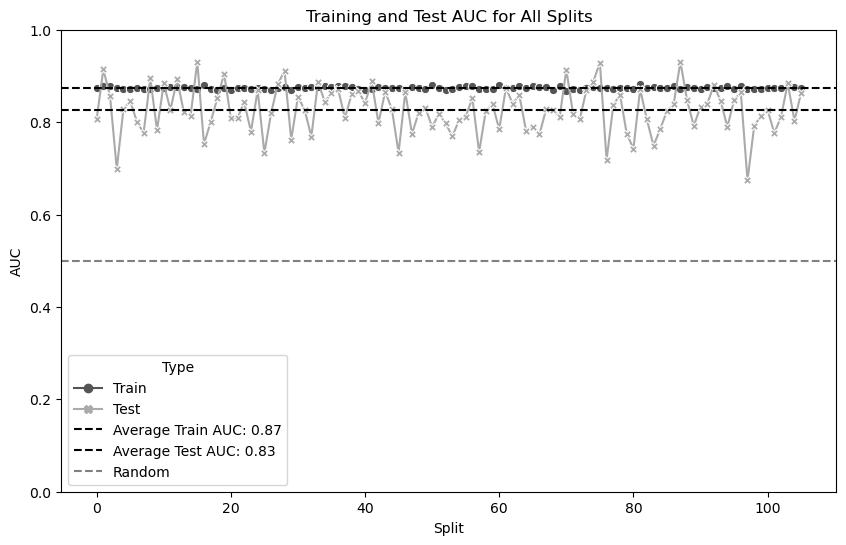

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'train_aucs' and 'test_aucs' are lists of AUC scores
splits = np.arange(len(train_aucs))  # Assuming splits are sequential and equal to the length of AUC lists

# Prepare a DataFrame for Seaborn
data = pd.DataFrame({
    'Split': np.concatenate([splits, splits]),  # Double the splits for train and test
    'AUC': np.concatenate([train_aucs, test_aucs]),  # Combine AUC scores
    'Type': ['Train']*len(train_aucs) + ['Test']*len(test_aucs)  # Label types
})

# Calculate the average values for training and test AUCs
avg_train_auc = sum(train_aucs) / len(train_aucs)
avg_test_auc = sum(test_aucs) / len(test_aucs)

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Set the color palette to black and white
palette = sns.color_palette("gray", n_colors=2)

# Draw a line plot with Seaborn
sns.lineplot(data=data, x='Split', y='AUC', hue='Type', style='Type', markers=True, dashes=False, palette=palette)

# Add average lines for Train and Test AUCs
plt.axhline(y=avg_train_auc, color='black', linestyle='--', label=f"Average Train AUC: {avg_train_auc:.2f}")
plt.axhline(y=avg_test_auc, color='black', linestyle='--', label=f"Average Test AUC: {avg_test_auc:.2f}")

# Line for random chance performance
plt.axhline(y=0.5, color='gray', linestyle='--', label="Random")

# Customize the axes and title
plt.xlabel('Split')
plt.ylabel('AUC')
plt.title('Training and Test AUC for All Splits')

# Show the legend and customize it to not show the color guide
plt.legend(title='Type')

# Set the ylim to standardize the AUC view
plt.ylim([0, 1])

# Display the plot
plt.show()


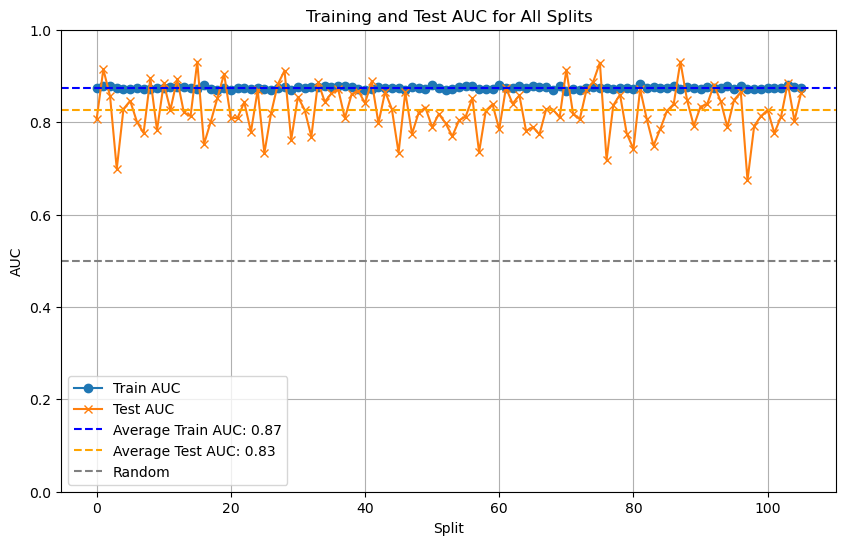

In [15]:
import matplotlib.pyplot as plt

# Calculate the average values for training and test AUCs
avg_train_auc = sum(train_aucs) / len(train_aucs)
avg_test_auc = sum(test_aucs) / len(test_aucs)

plt.figure(figsize=(10, 6))
plt.plot(train_aucs, label="Train AUC", marker='o')
plt.plot(test_aucs, label="Test AUC", marker='x')

# Add average lines for Train and Test AUCs
plt.axhline(y=avg_train_auc, color='blue', linestyle='--', label=f"Average Train AUC: {avg_train_auc:.2f}")
plt.axhline(y=avg_test_auc, color='orange', linestyle='--', label=f"Average Test AUC: {avg_test_auc:.2f}")

# Line for random
plt.axhline(y=0.5, color='gray', linestyle='--', label="Random")

plt.xlabel('Split')
plt.ylabel('AUC')
plt.title('Training and Test AUC for All Splits')
plt.legend()
plt.grid(True)
plt.ylim([0, 1])
plt.show()
